Welcome to Week 3 of our seminar on Applied Quantitative Methods in Finance. This week, we will delve into the intricacies of two-stage least squares (2SLS) regression, a powerful technique used to address violations of the exogeneity assumption in regression analysis. We will explore this method in two key scenarios: (1) using instrumental variables (IVs) to counteract endogeneity, and (2) calculating complex independent variables using 2SLS.

Exogeneity Violations: Simultaneity and Omitted Variables
- In classical regression analysis, we assume that the explanatory variables are exogenous, meaning they are not correlated with the error term. However, this assumption is often violated in practice due to:
  - Simultaneity: When there is a bidirectional causality between the dependent and independent variables.
  - Omitted Variables: When a relevant variable is left out of the model, causing the included variables to pick up the effect of the omitted ones.

These violations can lead to biased and inconsistent estimates, undermining the validity of our regression results.


Two-Stage Least Squares (2SLS) Regression is a method designed to address these issues by using instrumental variables (IVs) that are correlated with the endogenous predictors but uncorrelated with the error term. This approach involves two stages:
- First Stage: Regress the endogenous variable on the instrumental variables to obtain predicted values.
- Second Stage: Regress the dependent variable on the predicted values from the first stage.

By doing so, 2SLS helps isolate the variation in the endogenous variable that is exogenous, providing more reliable estimates.

As the ground work for this week's topic, please read Bascle (2008) and Ebbes et al. (2021).  

Bascle (2008) is an excellent article describing the causes of endonegenity in strategic management research and ways to manage it.  No need to focus on the detailed descriptions of all the different estimators, focus on understanding the causes and the overall approach to mitigate the resulting issues.  

While Ebbes (2021) is written in the context of marketing, it is an excellent introduction to the topic of endogeneity and its implications, using examples of demand elasticity.  It gives background information on the conditions that lead to endogeneity, why we need to mitigate it, and how we can accomplish this with IVs and 2SLS.  Pages 199-200 give a great reference point as to how to interpret an report 2SLS results in a paper. You can skip the section 'The Benefit of Panel Data'.

Ebbes, P., Papies, D., & van Heerde, H. J. (2021). Dealing with endogeneity: A nontechnical guide for marketing researchers. In Handbook of market research (pp. 181-217). Cham: Springer International Publishing.

Bascle, G. (2008). Controlling for endogeneity with instrumental variables in strategic management research. Strategic organization, 6(3), 285-327.

# Package Imports, WRDS Connection and Functions

In [1]:
# Basic imports of our data handling libraries
import pandas as pd
pd.set_option('display.max_columns', None) # display all columns
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.compat import lzip
import scipy.stats as stats
from scipy.stats.mstats import winsorize

# function for two-stage least squares
from linearmodels.iv import IV2SLS

# seaborn contains some useful pre-packaged plots for data reviews and regression analysis
import seaborn as sns
import matplotlib.pyplot as plt
 # configure plt so that it displays well within Jupyter notebooks
%matplotlib inline 

# library to display regression tables nicely
from IPython.display import HTML, display
from stargazer.stargazer import Stargazer

# we will use plotnine for our custom plots
from plotnine import ggplot, aes, geom_histogram, geom_line, geom_point, geom_hline, geom_density, geom_segment, \
                        facet_wrap, labs, theme, ggtitle, theme_minimal, scale_x_continuous, scale_y_continuous

In [2]:
# imports to enable WRDS access and SQL calls
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

In [3]:
# load password/username and connect to WRDS
load_dotenv()
connection_string = (
  "postgresql+psycopg2://"
 f"{os.getenv('WRDS_USER')}:{os.getenv('WRDS_PASSWORD')}"
  "@wrds-pgdata.wharton.upenn.edu:9737/wrds"
)
wrds_engine = create_engine(connection_string, pool_pre_ping=True)

## Functions

We will re-use the function from last week to generate advanced descriptive stats. 

In [67]:
def enhanced_descriptives (df_numeric):
    return pd.DataFrame({'variable':df_numeric.columns,
              'min':stats.describe(df_numeric)[1][0],
              'max':stats.describe(df_numeric)[1][1],
              'mean':stats.describe(df_numeric)[2],
              'std':np.sqrt(stats.describe(df_numeric)[3]),
              'median':df_numeric.median(axis=0),
              'skew':stats.skew(df_numeric, axis=0),
              'skew p-val':stats.skewtest(df_numeric)[1],
              'kurtosis':stats.kurtosis(df_numeric, axis=0),
              'normality test p-val': stats.normaltest(df_numeric, axis=0)[1] }).round(3)

# Project 1: Estimating Demand Elasticities using IV

In this exercise, we will analyze data collected from the Fulton Fish Market, historically located on Fulton Street in New York City before moving to the South Bronx in 2005. The market is renowned for its size and variety, being one of the largest fish markets globally.

(The data for this project comes from Graddy, Kathryn. 2006. “The Fulton Fish Market.” Journal of Economic Perspectives 20 (2): 207–20.)

The fish market's unique structure and the high heterogeneity of its products—ranging from over a hundred varieties of fish to numerous types of shrimp—make it an interesting case study. Buyers and sellers interact in a dynamic, two-sided platform, creating a dense and efficient market environment.

Our primary goal is to estimate the price elasticity of demand for fish, a measure of how quantity demanded responds to changes in price. This requires addressing the simultaneous determination of price and quantity, leading to endogeneity because clearly supply and demand are related (i.e. we need to tease out if the change in demand came from the price change, or from a supply change). To manage this issue, we will use an instrumental variable approach, employing the average maximum wave height from the two days preceding the fish's arrival as our instrument to isolate the effects of ommitted supply related variables. This variable is assumed to affect supply but not demand, allowing us to isolate the impact of price changes on quantity demanded.

We will examine the following model:

$log⁡(Q)=β0+β_1 log⁡(P)+β_2D+ϵ$


Where:
- $Q$ is the log quantity of fish sold in pounds
- $P$ is the log average daily price per pound
- $D$ includes day-of-week dummies and a time trend
- $ϵ$ is the error term

## Collect Data

This dataset for this exercise can be found on my GitHub site for your convenience.  It is the replication dataset for Graddy (2006), and publicly available on the MIT website.  The reason we are not building our own dataset for this exercise is that the definition and creation of IVs is an art that takes a lot of time.  For illustration purposes, we are using this proven dataset. 

The variable descriptions are as follows:
- prca: price for Asian buyers
- prcw: price for white buyers
- qtya: quantity sold to Asians
- qtyw: quantity sold to whites
- mon: =1 if Monday
- tues: =1 if Tuesday
- wed: =1 if Wednesday
- thurs: =1 if Thursday
- speed2: min past 2 days wind speeds
- wave2: avg max last 2 days wave height
- speed3: 3 day lagged max windspeed
- wave3: avg max wave hghts of 3 & 4 day lagged hghts
- avgprc: ((prca*qtya) + (prcw*qtyw))/(qtya + qtyw)
- totqty: qtya + qtyw
- lavgprc: log(avgprc)
- ltotqty: log(totqty)
- t: time trend
- lavgp_1: lavgprc[_n-1]
- gavgprc: lavgprc - lavgp_1
- gavgp_1: gavgprc[_n-1]

(see https://rdrr.io/cran/wooldridge/man/fish.html)



In [4]:
fish_ = pd.read_csv('https://raw.githubusercontent.com/emekelburg/DUEPHDFINMETHODS2024/main/graddy1995.csv')

In [5]:
fish_.head(3)

,Unnamed: 0,prca,prcw,qtya,qtyw,mon,tues,wed,thurs,speed2,wave2,speed3,wave3,avgprc,totqty,lavgprc,ltotqty,t,lavgp_1,gavgprc,gavgp_1
0,1,0.622222,0.766667,1875,2205,1,0,0,0,15,7.5,20,9.0,0.700286,4080,-0.356266,8.313852,1,NaN,NaN,NaN
1,2,0.972222,1.175000,2900,566,0,0,1,0,10,5.0,20,7.5,1.005336,3466,0.005322,8.150757,2,-0.356266,0.361588,NaN
2,3,1.233333,1.475000,770,1525,0,0,0,1,10,6.0,20,4.0,1.393918,2295,0.332118,7.738488,3,0.005322,0.326797,0.361588


## Variable Review

The data set has been reviewd and prepared for us, so we don't need to focus much time on data cleansing. 

In [6]:
df_ = fish_.get(["ltotqty","lavgprc","mon","tues","wed","thurs","t","wave2"]).copy()

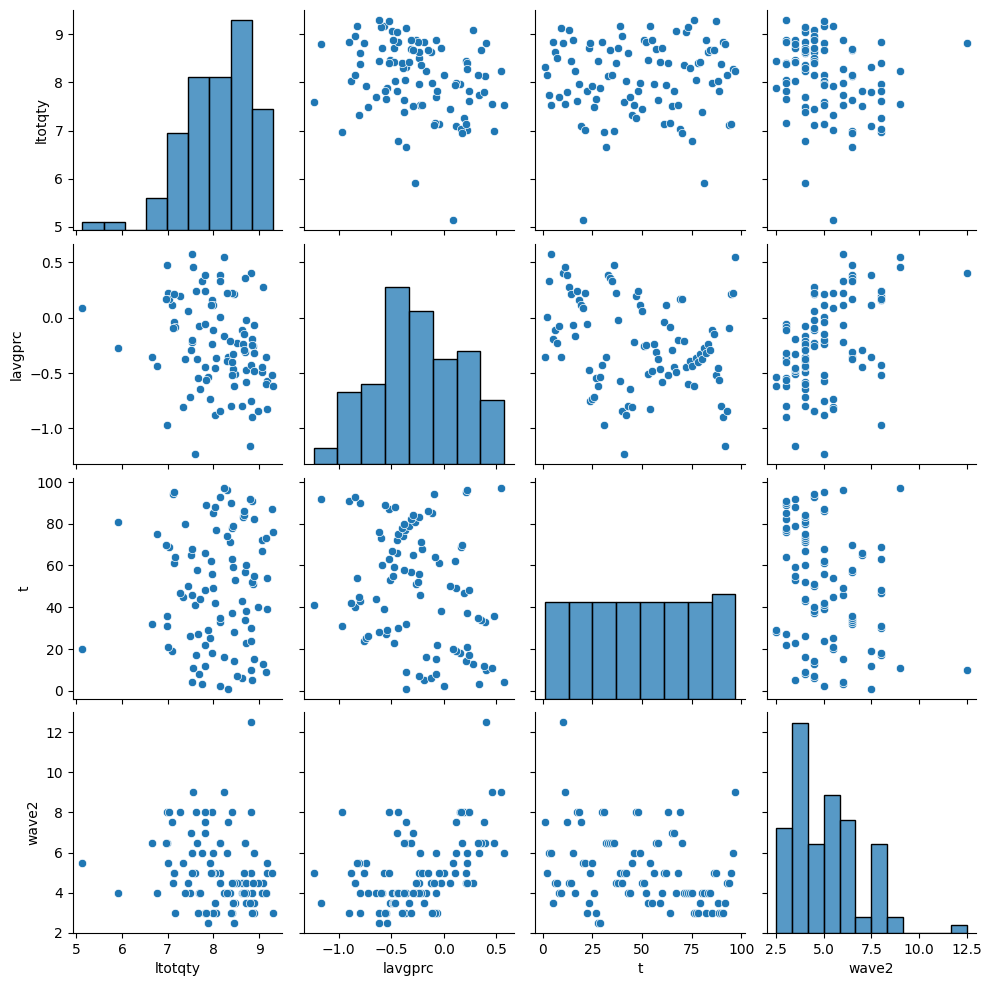

In [7]:
sns.pairplot(df_.drop(columns=["mon","tues","wed","thurs"]))

## OLS Regression

First we try to run this as a siple OLS regression of the price, and some dummies for day of week and time effects (inflation).  These results are our benchmark.

In [10]:
#OLS
fit_ols = smf.ols("ltotqty ~ lavgprc + mon + tues + wed + thurs + t", data = fish_).fit()
fit_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ltotqty   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     4.201
Date:                Mon, 20 May 2024   Prob (F-statistic):           0.000903
Time:                        03:35:18   Log-Likelihood:                -99.132
No. Observations:                  97   AIC:                             212.3
Df Residuals:                      90   BIC:                             230.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3011      0.203     40.935      0.000       7.898       8.704
lavgprc       -0.5489      0.184     -2.981      0.004      -0.915      -0.183
mon           -0.3175      0.227     -1.398      0.166      -0.769       0.134
tues          -0.6836      0.224     -3.057      0.003      -1.128      -0.239
wed           -0.5353      0.221     -2.423      0.017      -0.974      -0.096
thurs          0.0683      0.221      0.308      0.759      -0.372       0.508
t             -0.0012      0.003     -0.473      0.637      -0.006       0.004
==============================================================================
Omnibus:                       18.269   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.771
Skew:                          -0.853   Prob(JB):                     1.54e-06
Kurtosis:                       4.926   Cond. No.                         305.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
fit_ = fit_ols

Heterogeneity test is non significant, so we're fine here.

In [30]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(fit_.resid, fit_.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.925590323803065),
 ('p-value', 0.5533916193799784),
 ('f-value', 0.802436367682154),
 ('f p-value', 0.5705877230140896)]

Residuals look relatively evenly distributed.

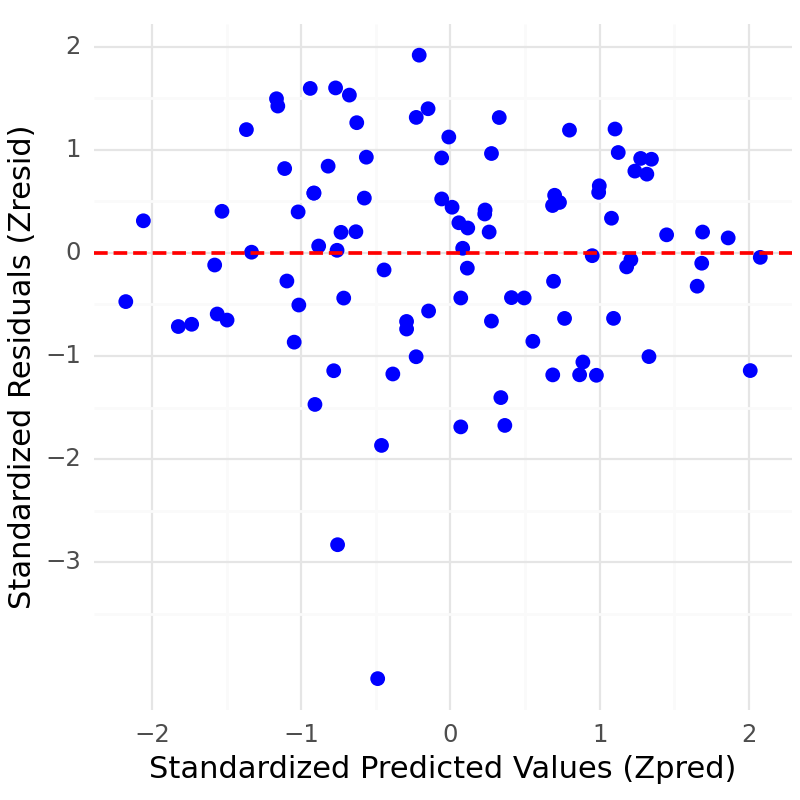

<Figure Size: (400 x 400)>

In [14]:
# Get predicted values and residuals
predicted_values = fit_.predict(df_)
residuals = fit_.resid

# Create a plot dataframe with normalized values
plot_data = pd.DataFrame({
    'Zpred': (predicted_values - np.mean(predicted_values)) / np.std(predicted_values),
    'Zresid': (residuals - np.mean(residuals)) / np.std(residuals)
})

# Create the plot
(
    ggplot(plot_data, aes(x='Zpred', y='Zresid'))  # Define the data and aesthetic mapping
    + geom_point(color='blue', size=2)  # Scatterplot points
    + geom_hline(yintercept=0, color='red', linetype='dashed', size=0.75)  # Horizontal line at zero
    + labs(x='Standardized Predicted Values (Zpred)', y='Standardized Residuals (Zresid)')  # Labels
    + theme_minimal()  # Minimal theme for a clean look
    + scale_x_continuous(breaks=np.arange(-3, 4, 1))  # Customize the x-axis breaks
    + scale_y_continuous(breaks=np.arange(-3, 4, 1))  # Customize the y-axis breaks
    + theme(figure_size=(4, 4)) 
)

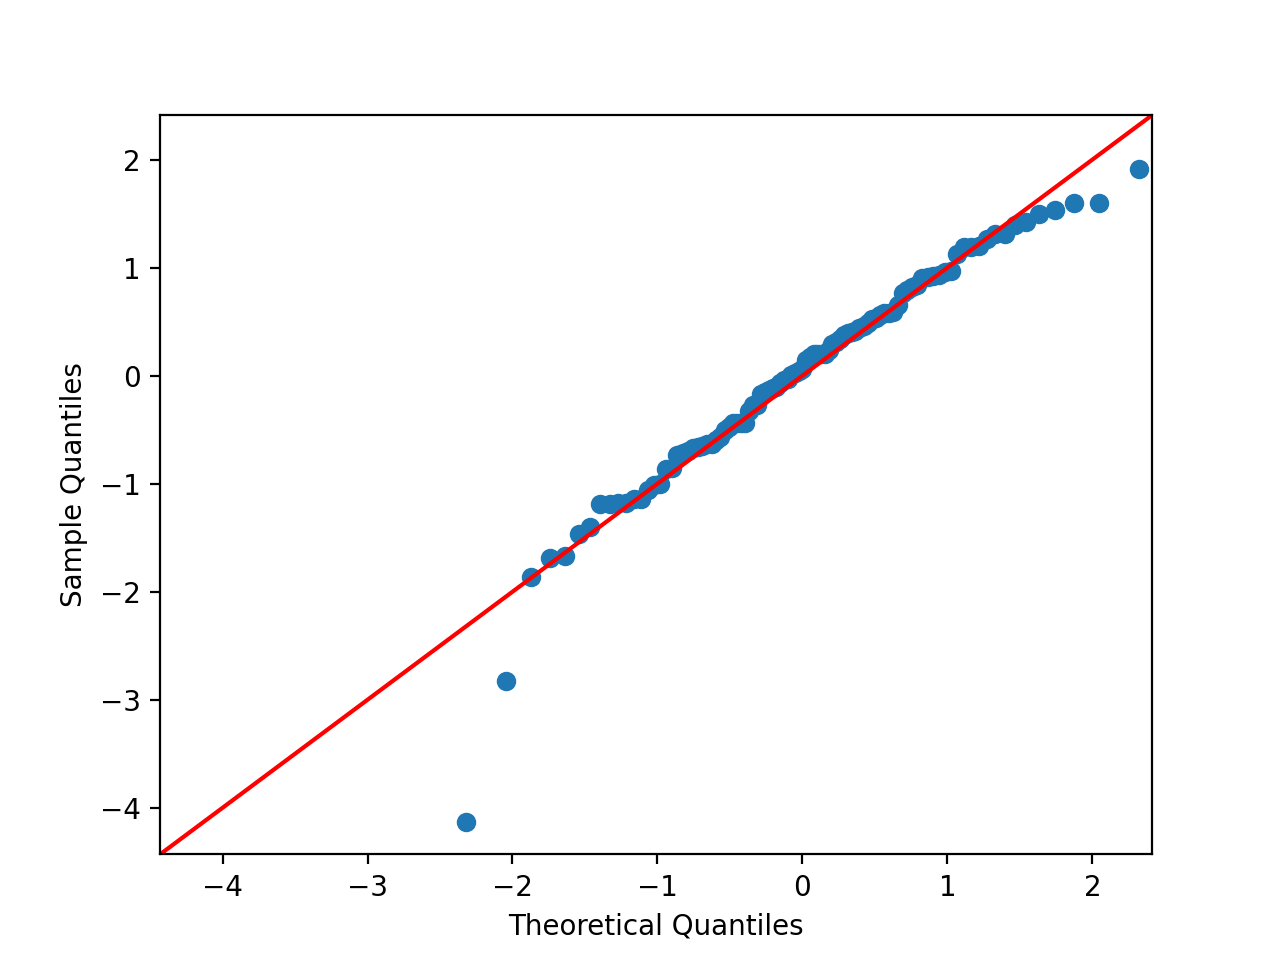

In [15]:
sm.qqplot(fit_.resid,  fit=True, line='45');

Variance inflation looks good, no strong multicollinearity.

In [20]:
df_VIF_selected = df_.get(["lavgprc","mon","tues","wed","thurs","t"])

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df_VIF_selected.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_VIF_selected.values, i) 
                          for i in range(len(df_VIF_selected.columns))] 
vif_data

,feature,VIF
0,lavgprc,1.494360
1,mon,1.293401
2,tues,1.380210
3,wed,1.373738
4,thurs,1.392163
5,t,2.876497


Cook's distance shows two strong outliers.  (For an academic paper, the best practice is to fit the regression again after removing these outliers and then compare the results.)

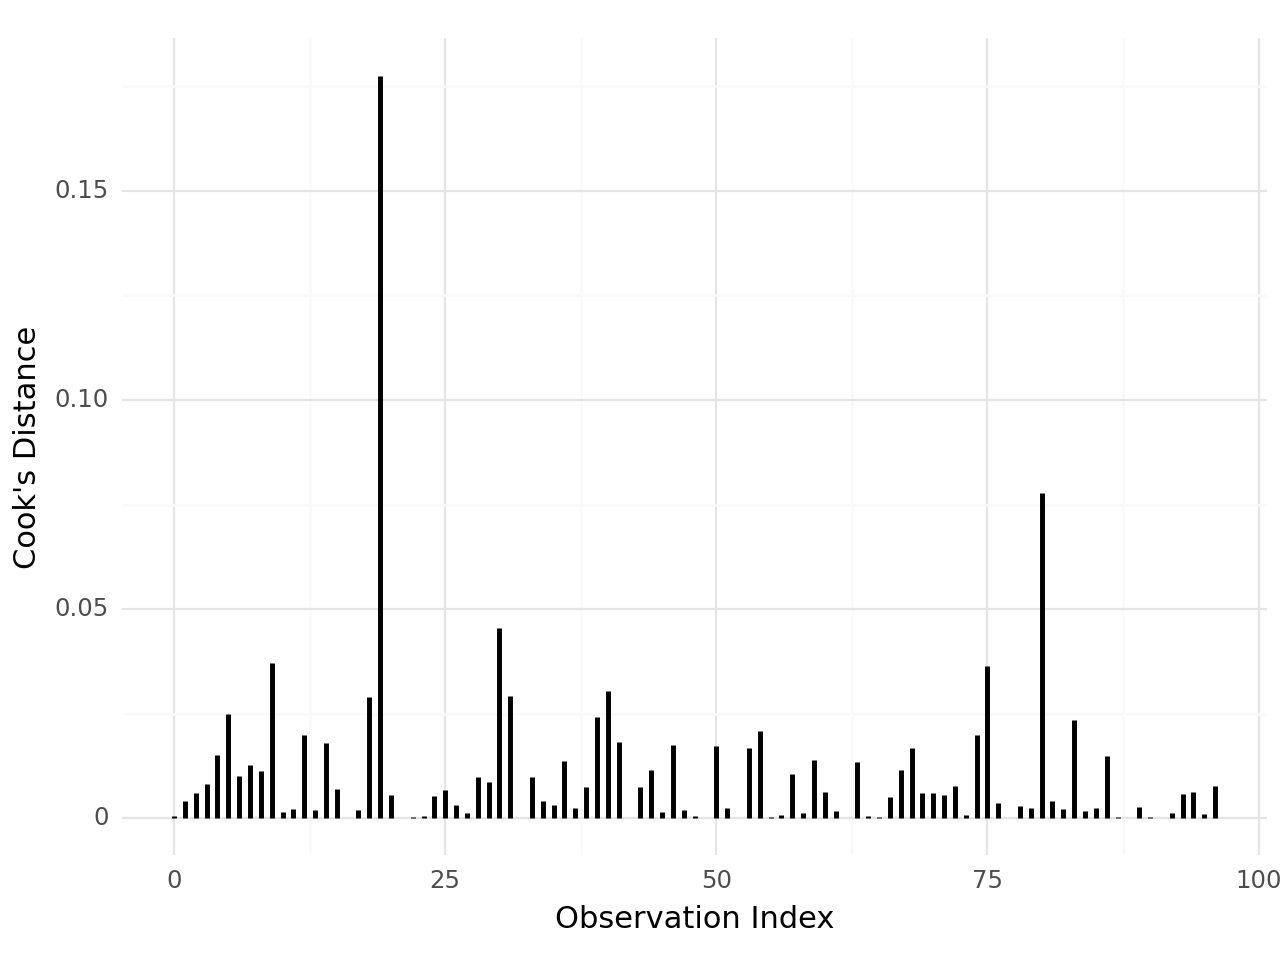

<Figure Size: (640 x 480)>

In [16]:
# Calculate influence measures
influence = fit_.get_influence()

# Obtain Cook's distance for each observation
cooks_d, pvals = influence.cooks_distance

# Create DataFrame for plotting
data = pd.DataFrame({
    'Observation Index': np.arange(len(cooks_d)),
    'Cook\'s Distance': cooks_d
})

(
    ggplot(data, aes(x='Observation Index', y='Cook\'s Distance'))
    + geom_segment(aes(x='Observation Index', xend='Observation Index', y=0, yend='Cook\'s Distance'), size=1)  # Create vertical lines (like stems)
    #+ geom_point(shape='o', color='blue', size=2)  # Add points to the tips of stems
    + labs( x='Observation Index', y="Cook's Distance")
    + theme_minimal()  # Apply a minimalistic theme
)

## 2SLS with IV

Next we fit the regression using an IV approach with the average maximum wave height over the last two days as our instrument.  The logic here is that the higher the waves, the harder it is to fish, which affects supply, but should have no effect on demand.  Regressing the wave height on the price first takes the variation related to supply shocks out of the price movement and therefore out of the error term of the second stage regression. 

The IV2SLS function has a unique short-hand syntax where the endogenous variable (lavgprc) and the intrument (wave2) are writted in brackets at the end of the formula, telling the system to carry out that regression first, and then use the predicted values from it in the second stage regression. 

In [18]:
#2SLS
fit_IV = IV2SLS.from_formula(formula = "ltotqty ~ 1 + mon + tues + wed + thurs + t + [lavgprc ~ wave2]", data = df_).fit()
fit_IV.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                ltotqty   R-squared:                      0.1755
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1205
No. Observations:                  97   F-statistic:                    25.209
Date:                Mon, May 20 2024   P-value (F-stat)                0.0003
Time:                        03:45:10   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      8.2711     0.1805     45.829     0.0000      7.9173      8.6248
mon           -0.3217     0.2345    -1.3720     0.1700     -0.7812      0.1378
tues          -0.6873     0.2038    -3.3728     0.0007     -1.0866     -0.2879
wed           -0.5198     0.2166    -2.3996     0.0164     -0.9444     -0.0952
thurs          0.1055     0.1769     0.5966     0.5508     -0.2412      0.4522
t             -0.0029     0.0028    -1.0285     0.3037     -0.0084      0.0026
lavgprc       -0.9603     0.4395    -2.1849     0.0289     -1.8218     -0.0989
==============================================================================

Endogenous: lavgprc
Instruments: wave2
Robust Covariance (Heteroskedastic)
Debiased: False
"""

No evidence for heteroskedasticity violations.

In [36]:
fit_ = fit_IV

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(fit_.resids, fit_.model.exog.ndarray)
lzip(name, test)

[('Lagrange multiplier statistic', 5.476136239890878),
 ('p-value', 0.3605697253406342),
 ('f-value', 1.0889583926138133),
 ('f p-value', 0.3719242997713742)]

Relatively well distributed residuals.

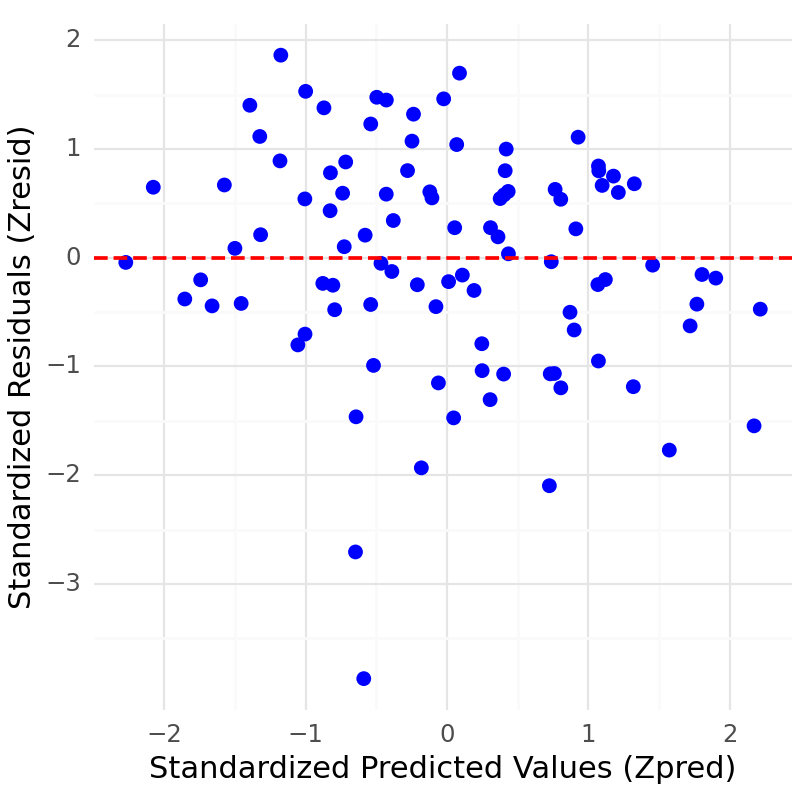

<Figure Size: (400 x 400)>

In [50]:
# Get predicted values and residuals
predicted_values = fit_.predict(data=df_)["predictions"]
residuals = fit_.resids

# Create a plot dataframe with normalized values
plot_data = pd.DataFrame({
    'Zpred': (predicted_values - np.mean(predicted_values)) / np.std(predicted_values),
    'Zresid': (residuals - np.mean(residuals)) / np.std(residuals)
})

# Create the plot
(
    ggplot(plot_data, aes(x='Zpred', y='Zresid'))  # Define the data and aesthetic mapping
    + geom_point(color='blue', size=2)  # Scatterplot points
    + geom_hline(yintercept=0, color='red', linetype='dashed', size=0.75)  # Horizontal line at zero
    + labs(x='Standardized Predicted Values (Zpred)', y='Standardized Residuals (Zresid)')  # Labels
    + theme_minimal()  # Minimal theme for a clean look
    + scale_x_continuous(breaks=np.arange(-3, 4, 1))  # Customize the x-axis breaks
    + scale_y_continuous(breaks=np.arange(-3, 4, 1))  # Customize the y-axis breaks
    + theme(figure_size=(4, 4)) 
)


Some outliers visible on the QQ. 

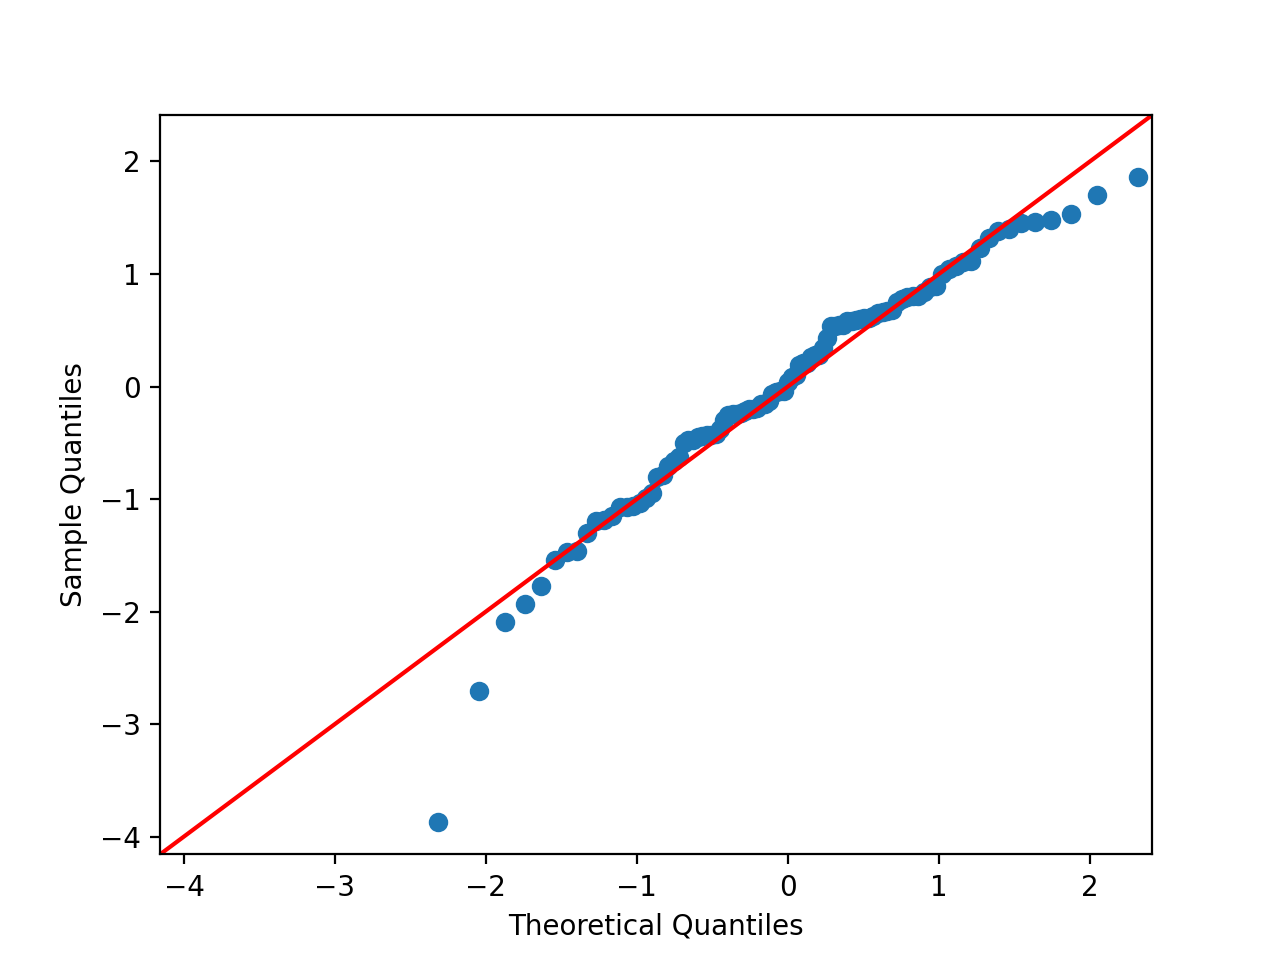

In [51]:
sm.qqplot(fit_.resids,  fit=True, line='45');

The first stage exhibits strong F-stat and significant coefficient of wave2 on price.  Notice how all the independent variables are in this regression, this is common in IV estimation. 

In [576]:
fit_IV.first_stage

,lavgprc
R-squared,0.2693
Partial R-squared,0.2010
Shea's R-squared,0.2010
Partial F-statistic,27.275
P-value (Partial F-stat),1.765e-07
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,-0.7056
,(-4.6360)
mon,-0.0365


A comparison of the two methods shows that the IV approach, controlling for endogeneity, has much higher demand elasticity than the OLS regression. 

In [23]:
stargazer = Stargazer([fit_ols, fit_IV])

stargazer.custom_columns(['OLS', '2SLS-IV'], [1, 1])
stargazer.add_custom_notes(['IV instrument wave height was found to be strong at F-stat of 27.275.'])

# Render HTML (useful for Jupyter Notebooks) or get LaTeX code
html_output = stargazer.render_html()
#print(html_output) 
display(HTML(html_output))

In [21]:
df_.corr()

,ltotqty,lavgprc,mon,tues,wed,thurs,t,wave2
ltotqty,1.000000,-0.261038,-0.008731,-0.243942,-0.170516,0.215008,0.038823,-0.213628
lavgprc,-0.261038,1.000000,-0.021143,-0.044733,0.019993,0.081966,-0.276149,0.474636
mon,-0.008731,-0.021143,1.000000,-0.235587,-0.243272,-0.243272,-0.064402,0.131692
tues,-0.243942,-0.044733,-0.235587,1.000000,-0.251535,-0.251535,0.021338,-0.003841
wed,-0.170516,0.019993,-0.243272,-0.251535,1.000000,-0.259740,-0.004550,-0.076755
thurs,0.215008,0.081966,-0.243272,-0.251535,-0.259740,1.000000,0.013651,-0.083921
t,0.038823,-0.276149,-0.064402,0.021338,-0.004550,0.013651,1.000000,-0.294044
wave2,-0.213628,0.474636,0.131692,-0.003841,-0.076755,-0.083921,-0.294044,1.000000


Interpretation: 

First Stage Instrument		
Average wave height		
Robust standard error		(0.022)
F statistic for IV in first stage		22.638

## Results

In this analysis, we examine the relationship between various factors and the total quantity of fish sold (log-transformed, ltotqty) at the Fulton Fish Market, using both ordinary least squares (OLS) regression and an instrumental variables (IV) approach via two-stage least squares (2SLS). The IV approach is employed to address potential endogeneity in the price variable (lavgprc).

The OLS regression results indicate that approximately 21.9% of the variability in the total quantity of fish sold is explained by the model, as reflected in an R-squared value of 0.219. The coefficient for the log average price (lavgprc) is -0.5489, which is statistically significant with a p-value of 0.004. This negative coefficient implies that higher prices are associated with lower quantities sold. Additionally, the day-of-the-week variables for Tuesday and Wednesday (tues and wed) are significantly negative, indicating lower quantities sold on these days compared to the base day, which is likely Friday. The variables for Monday (mon), Thursday (thurs), and the trend variable (t) are not statistically significant in this model.

In the first stage of the IV regression, the goal is to predict lavgprc using the instrument wave2 along with other predictors. The first stage regression results show an R-squared of 0.2693 and a partial R-squared of 0.2010, indicating that about 20.1% of the variability in lavgprc is explained by the instrument and the included variables. The coefficient for wave2 is 0.1028, which is highly significant with a p-value less than 0.0001. This strong significance suggests that wave2 is a robust predictor of lavgprc.

The second stage of the IV regression reveals that the model explains about 17.55% of the variability in the total quantity sold, with an R-squared value of 0.1755. In this stage, the coefficient for lavgprc is -0.9603, which is statistically significant with a p-value of 0.0289. The magnitude of this coefficient is larger than that in the OLS model, suggesting that accounting for endogeneity increases the estimated negative impact of price on quantity sold. The day-of-the-week variables for Tuesday and Wednesday remain significantly negative, consistent with the OLS results, while the variables for Monday, Thursday, and the trend variable are not significant, similar to the OLS findings.

The strength of the instrumental variable wave2 is assessed using several statistics from the first stage regression. The partial R-squared value of 0.2010 indicates a strong relationship between the instrument and the endogenous regressor lavgprc. The partial F-statistic of 27.275 is well above the commonly used threshold of 10 for considering an instrument strong, and the extremely low p-value of 1.765e-07 confirms the instrument's high statistical significance. These statistics collectively confirm that wave2 is a strong instrument for lavgprc, providing confidence in the validity of the 2SLS estimates.  However, we do find a relatively strong correlation between the quantity sold and wave height, which puts pressure on the exclusion condition.  

# Project 2: Earnings Management and 2SLS

Earnings management involves the deliberate manipulation of financial statements to achieve specific internal or external objectives. Managers may influence financial reporting through various accounting choices and operational decisions, potentially affecting stakeholders’ perceptions of a company's performance and health.

Objectives of Earnings Management
- Companies may manage earnings to meet analysts' forecasts, maintain consistent growth patterns, or avoid reporting losses, which can influence stock prices and managerial compensation.
- Regulatory Compliance: Firms might manipulate earnings to comply with debt covenants or regulatory requirements.
- Taxation: Managing earnings can help in reducing taxable income, thereby lowering tax liabilities.
- Personal Management Incentives: Executives may have bonuses tied to specific financial targets, providing personal incentives to adjust earnings figures.

Earnings management can be conducted through two main methods, 
- Accrual-Based Adjustments: This involves changing assumptions and estimates used in accruals, such as depreciation methods, provisions for doubtful debts, or inventory valuation methods.
- Real Activities Manipulation: This includes actions like changing the timing of sales, overproduction to reduce costs, or deferring maintenance expenses.

Detecting earnings management typically involves statistical models that identify abnormal accruals, with the Jones Model being one of the most prominent methods. This model estimates normal accruals based on changes in revenue and property, plant, and equipment, and identifies discretionary accruals as residuals that might indicate managed earnings.

While earnings management is not illegal per se (provided it complies with accounting standards), it raises ethical concerns and can mislead stakeholders about the true financial position and performance of a company. Excessive earnings management can lead to a loss of market confidence, reduced investment, and can be a red flag for deeper financial troubles or fraud.

This research project aims to investigate a number of hypotheses related to earnings managment: 

- H1: Impact of Discretionary Accruals on Firm Performance - Discretionary accruals are positively associated with log ROA. This hypothesis posits that management might use discretionary accruals to optimistically influence earnings to meet or beat benchmarks, thereby artificially boosting the firm’s apparent performance. A positive coefficient would suggest that higher discretionary accruals lead to higher reported profitability, reflecting potential earnings management to create a more favorable impression of financial health.

- H2: Influence of Firm Size - The impact of discretionary accruals on log ROA varies by firm size. Larger firms, due to their more significant analyst following and greater scrutiny, may have less room to manipulate earnings or might do so more efficiently due to more sophisticated financial practices. Thus, the effect of discretionary accruals on ROA might be smaller or managed differently in larger firms compared to smaller firms. This can be tested by including an interaction term between discretionary accruals and firm size.

- H3: Role of Market to Book Ratio - The effect of discretionary accruals on log ROA is influenced by the market to book ratio. A high market to book ratio often reflects higher growth expectations by the market. Firms with high expectations might be under more pressure to manage earnings through discretionary accruals to sustain or justify their market valuations. This hypothesis would suggest a significant interaction between the market to book ratio and discretionary accruals.

This research will use the Jones Model, a widely used statistical method to detect earnings management by isolating the portion of total accruals that can be attributed to discretionary decisions by management, as opposed to those driven by changes in the economic environment or required by accounting standards. It is a fundamental tool in accounting research for identifying abnormal (discretionary) accruals and study their impact.

It aims to estimate normal accruals based on a firm’s operations. The difference between the total accruals and these estimated normal accruals gives the discretionary accruals, which are often interpreted as an indicator of earnings management.  Because there is no direct measure of discretionary accruals, this is done using a two-stage regression, the first stage is the estimation of non-discretionary (normal) accruals.  The residuals from the first-stage regression are the estimated discretionary accruals, which suggest the level of earnings management, and these are in turn used in a second stage regression. We will review the impact of discretionary accruals on ROA. 

## Data Collection

We collect annual report data from Compustat.    You can find the data definitions here: https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-annual/ (Go to the Variable Descriptions tab.)

In [53]:
compustat_data_raw = pd.read_sql_query(
    sql=f" \
        SELECT gvkey, tic, datadate, ni, at, act, che, lct, dlc, dp, sale, rect, ppegt, fyear, \
               csho, prcc_f, ceq \
        FROM comp.funda \
        WHERE (indfmt='INDL' AND datafmt='STD' AND popsrc='D' AND consol='C') \
        AND fyear >= 2010 AND fyear <= 2023 \
    ",
    con=wrds_engine,
)

In [54]:
compustat_data_raw.head(3)

,gvkey,tic,datadate,ni,at,act,che,lct,dlc,dp,sale,rect,ppegt,fyear,csho,prcc_f,ceq
0,001004,AIR,2011-05-31,69.826,1703.727,913.985,57.433,416.010,114.075,59.296,1775.782,296.489,652.862,2010,39.781,26.39,835.845
1,001013,ADCT.1,2010-09-30,62.000,1474.500,1107.700,696.900,288.700,0.300,61.500,1156.600,252.500,556.300,2010,97.200,12.67,429.600
2,001019,AFAP,2010-12-31,0.997,29.546,20.087,2.387,16.353,1.358,2.053,72.433,12.256,68.006,2010,0.153,240.00,1.504


## Variable Calculation

Our variables include ones calculated using changes in the annual financial statement metrics. To calculate these changes effectively, we need to group the financial statements by firm (groupby tic).  

In [55]:
# calculate grouped values for total assets, change in sales and change in receivables 
compustat_data = (compustat_data_raw
                  .assign(
                      lag_at = lambda x: x.groupby('tic')['at'].transform(lambda y: y.shift(1)), # lag Total Assets
                      delta_rev = lambda x: x.groupby('tic')['sale'].transform(lambda y: (y - y.shift(1)) / y.shift(1)),
                      delta_rec = lambda x: x.groupby('tic')['rect'].transform(lambda y: (y - y.shift(1)) / y.shift(1)),
                  )
                 )

Calculate total accruals (TA). This metric is commonly used in accounting and financial analysis to measure the non-cash component of earnings. Here's a breakdown of the calculation using Compustat data variables:
Breakdown of the Calculation

$ta=(act−che)−(lct−dlc)+dp$

Components:
- act (Current Assets): This represents the total current assets of the firm, which are assets expected to be converted to cash or used within one year. The act variable in Compustat corresponds to this.
- che (Cash and Cash Equivalents): This is the portion of current assets that is held as cash or can be quickly converted to cash. The che variable in Compustat corresponds to this.
- lct (Current Liabilities): This represents the firm's obligations that are due within one year. The lct variable in Compustat corresponds to this.
- dlc (Debt in Current Liabilities): This includes short-term borrowings and the current portion of long-term debt that is due within one year. The dlc variable in Compustat corresponds to this.
- dp (Depreciation and Amortization): This represents the non-cash expenses related to the depreciation of fixed assets and amortization of intangible assets. The dp variable in Compustat corresponds to this.

In [56]:
# Function to calculate total accruals
def calculate_ta(group):
    group['ta'] = (group['act'] - group['che']) - (group['lct'] - group['dlc']) + group['dp']
    return group
compustat_data = compustat_data.groupby('tic').apply(calculate_ta).reset_index(drop=True)

/tmp/ipykernel_94834/4177895122.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


For our second stage regression we prepare some general firm metrics. 

In [57]:
# Calculate additional variables for stage 2
compustat_data['firm_size'] = compustat_data['csho'] * compustat_data['prcc_f'] # Using Market Cap as a measure of firm size (shares outstanding times price at end of fiscal year)
compustat_data['market_to_book'] = compustat_data['firm_size'] / compustat_data['ceq']  # market cap divided by Common/Ordinary Equity

Micro Cap and Small Cap stocks contain strong outliers and we will remove these from the dataset. 

In [58]:
# we also exclude micro-cap stock because they tend to have more outliers that skew the analysis
#   we define micro-caps and small stocks as less than $1 Billion in market cap
compustat_data = compustat_data[(compustat_data['firm_size'] >= 1000)]

In [59]:
# remove the NAs from the calculated fields
compustat_data = compustat_data.dropna()

For the outcome variables we have normalized total accruals (first stage) and return on assets (second stage)

In [60]:
# calculate the outcome variables

#first stage
compustat_data['norm_ta'] = compustat_data['ta'] / compustat_data['lag_at']

#second stage
compustat_data['roa'] = compustat_data.apply(lambda x: x['ni'] / x['at'] if x['at'] != 0 else None, axis=1)

In some cases, nda and norm_ta will encounter division by zero, leading to -inf values.  We need to remove these before running the regressions.

In [61]:
# Replace -inf and inf with NaN
compustat_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN values
compustat_data.dropna(inplace=True)

In [62]:
# check how many rows we have left in the data set
len(compustat_data)

25284

In [63]:
compustat_data[compustat_data['tic']=="COST"].head(3)

,gvkey,tic,datadate,ni,at,act,che,lct,dlc,dp,sale,rect,ppegt,fyear,csho,prcc_f,ceq,lag_at,delta_rev,delta_rec,ta,firm_size,market_to_book,norm_ta,roa
32088,029028,COST,2011-08-31,1462.0,26761.0,13706.0,5613.0,12050.0,903.0,855.0,88915.0,965.0,18368.0,2011,434.266,78.54,12002.0,23815.0,0.140726,0.091629,-2199.0,34107.25164,2.841797,-0.092337,0.054632
32089,029028,COST,2012-08-31,1709.0,27140.0,13526.0,4854.0,12260.0,3.0,908.0,99137.0,1026.0,19546.0,2012,432.350,97.87,12361.0,26761.0,0.114964,0.063212,-2677.0,42314.09450,3.423193,-0.100034,0.062970
32090,029028,COST,2013-08-31,2039.0,30283.0,15840.0,6124.0,13257.0,40.0,946.0,105156.0,1201.0,21022.0,2013,436.839,111.87,10833.0,27140.0,0.060714,0.170565,-2555.0,48869.17893,4.511140,-0.094141,0.067332


## Data Preparation for First Stage

In [65]:
adjusted_dataset = ( compustat_data
       .copy()
       .get(["norm_ta","lag_at","delta_rev","delta_rec","ppegt",  # stage 1 data
             "roa", "firm_size", "market_to_book"])  # stage 2 data
      )

The variable distributions are very non-normal based on descriptives, and we need to work on cleaning them. 

In [68]:
enhanced_descriptives(adjusted_dataset)

,variable,min,max,mean,std,median,skew,skew p-val,kurtosis,normality test p-val
norm_ta,norm_ta,-10.988,5.169,0.076,0.194,0.071,-8.209,0.0,504.315,0.0
lag_at,lag_at,0.366,603595.692,16182.141,39962.725,3809.362,5.966,0.0,47.806,0.0
delta_rev,delta_rev,-10.699,1271.549,0.352,9.996,0.074,98.863,0.0,11434.983,0.0
delta_rec,delta_rec,-1.000,1917.688,0.552,17.519,0.075,80.952,0.0,7499.842,0.0
ppegt,ppegt,0.000,635149.061,11222.744,35101.140,1711.807,7.563,0.0,75.549,0.0
roa,roa,-1040.755,2.507,-0.006,6.547,0.044,-158.880,0.0,25253.580,0.0
firm_size,firm_size,1000.109,2662325.944,18541.352,65822.211,4506.274,18.736,0.0,531.598,0.0
market_to_book,market_to_book,-31580.237,570555.556,40.109,4138.807,2.731,121.313,0.0,15611.611,0.0


Normalized accruals have a long tailed distribution. 

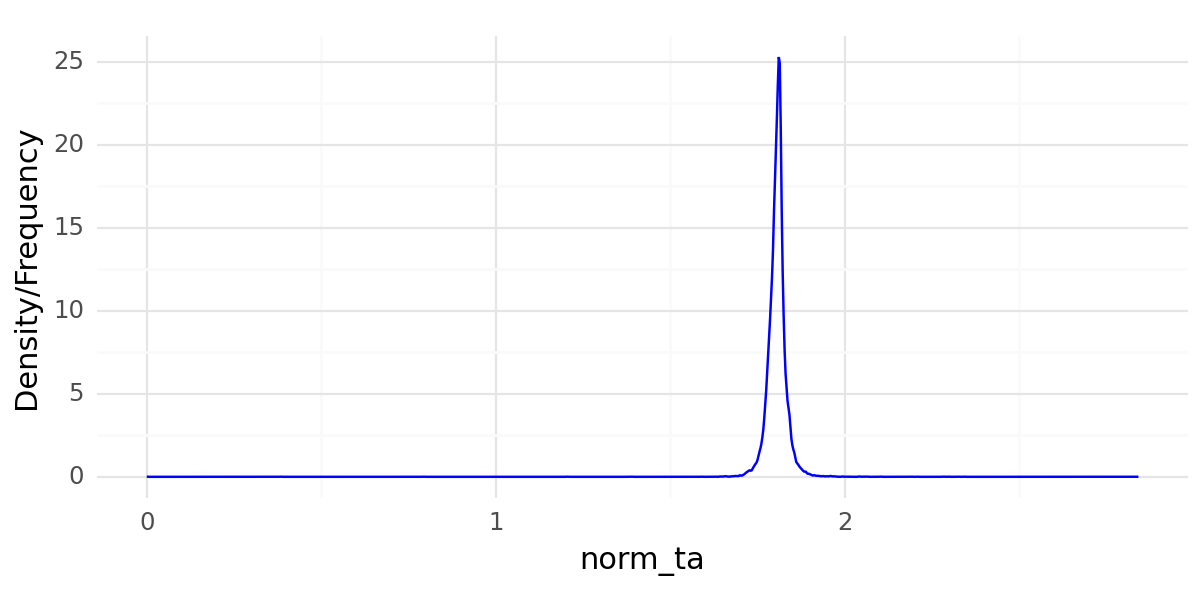

<Figure Size: (600 x 300)>

In [72]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='norm_ta', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))2
)

A review of the dataset reveals a small number of extreme outliers.

In [75]:
len(adjusted_dataset[(adjusted_dataset['norm_ta']<-1) | ((adjusted_dataset['norm_ta']>2))])

24

We inverse and log adjust to mitigate the large tails. 

In [76]:
adjusted_dataset = (adjusted_dataset
 .assign(
     norm_ta = lambda x: np.log( x['norm_ta'].max() - x['norm_ta'] + 1 )
 )
)

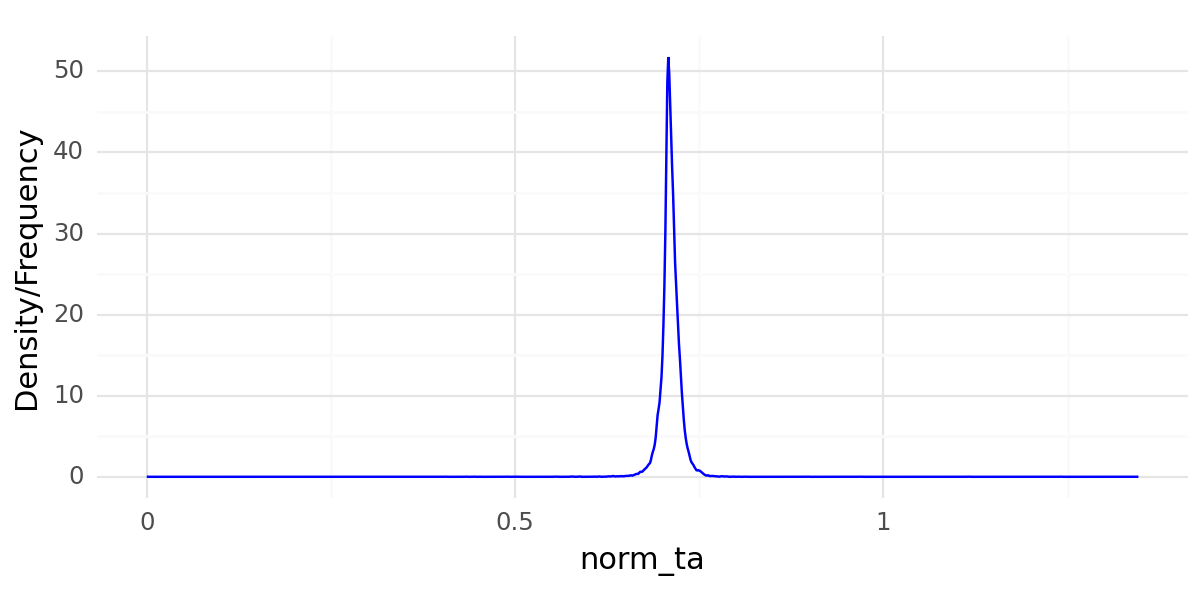

<Figure Size: (600 x 300)>

In [77]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='norm_ta', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Lag assets exhibit a distribution with a strong tail and we adjust using the log. 

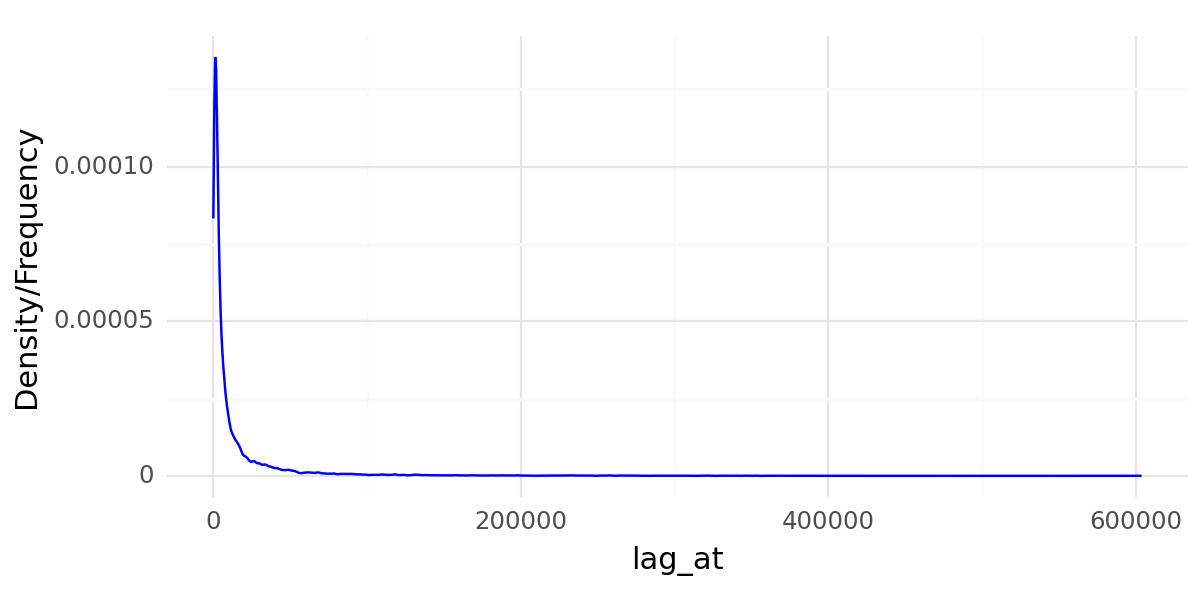

<Figure Size: (600 x 300)>

In [78]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='lag_at', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [79]:
adjusted_dataset = (adjusted_dataset
 .assign(
     lag_at = lambda x:  np.log(x['lag_at'])
 )
)

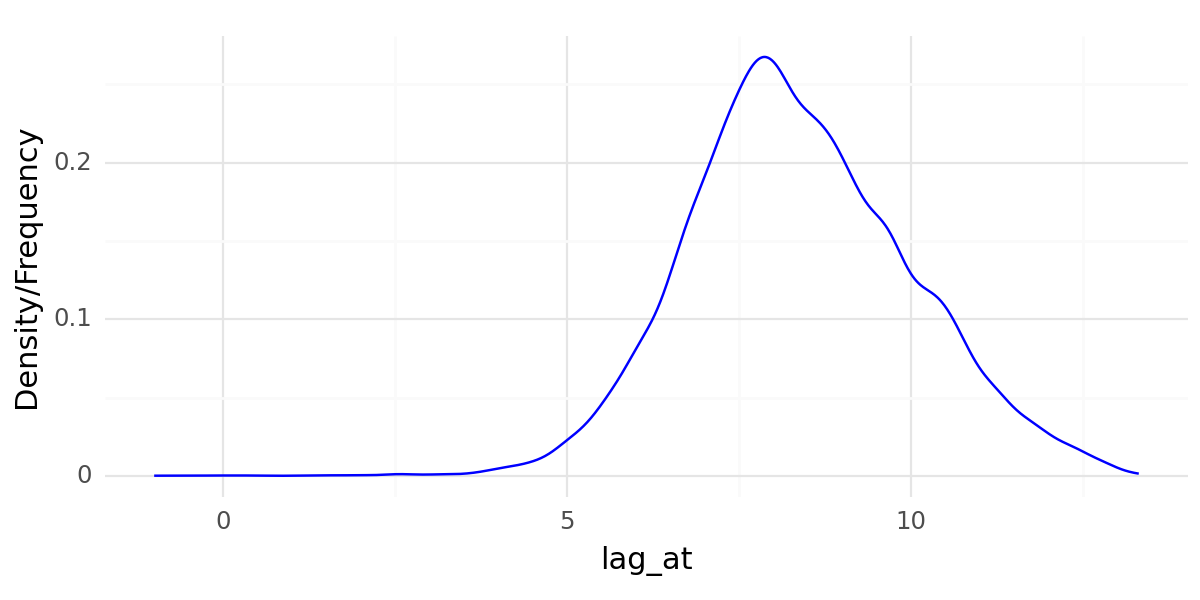

<Figure Size: (600 x 300)>

In [80]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='lag_at', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Changes in revenues exhibit some strong outliers as well. 

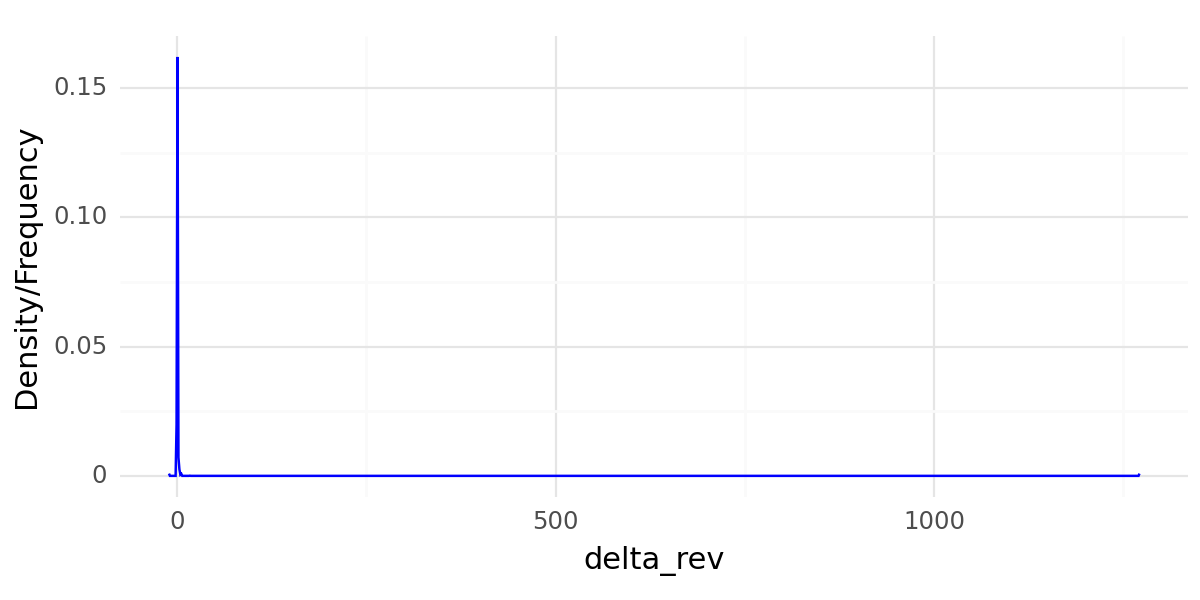

<Figure Size: (600 x 300)>

In [81]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='delta_rev', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [82]:
adjusted_dataset = (adjusted_dataset
 .assign(
     delta_rev = lambda x:  np.log(x['delta_rev'])
 )
)

/home/erik/jupyterlab/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
/home/erik/jupyterlab/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log


/home/erik/jupyterlab/env/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 6758 rows containing non-finite values.


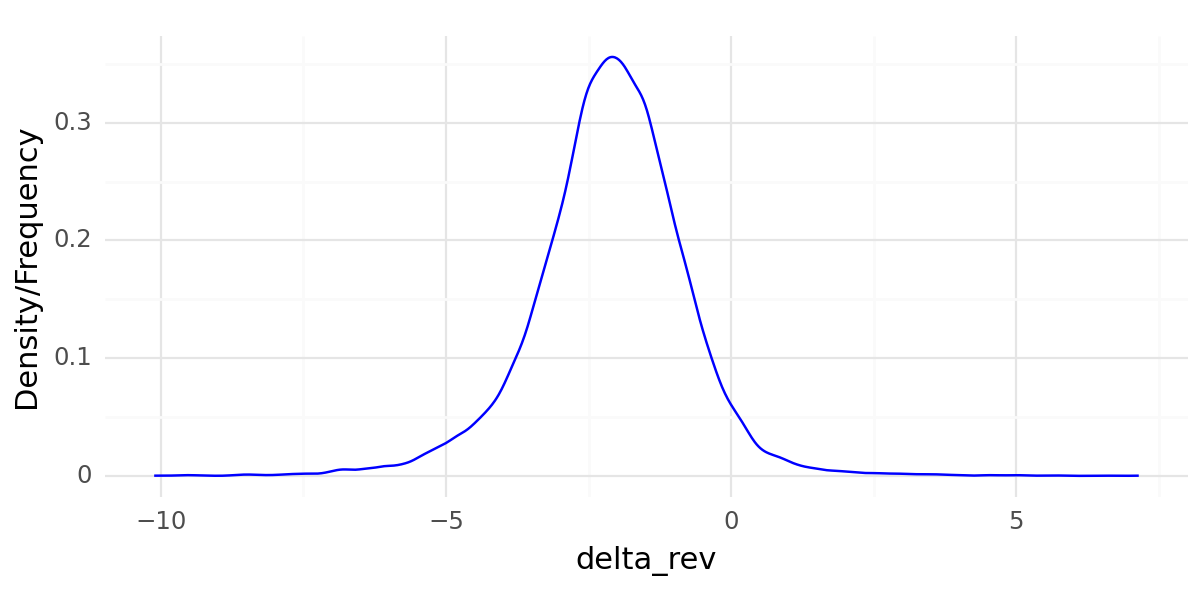

<Figure Size: (600 x 300)>

In [83]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='delta_rev', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Same with changes in receivables.

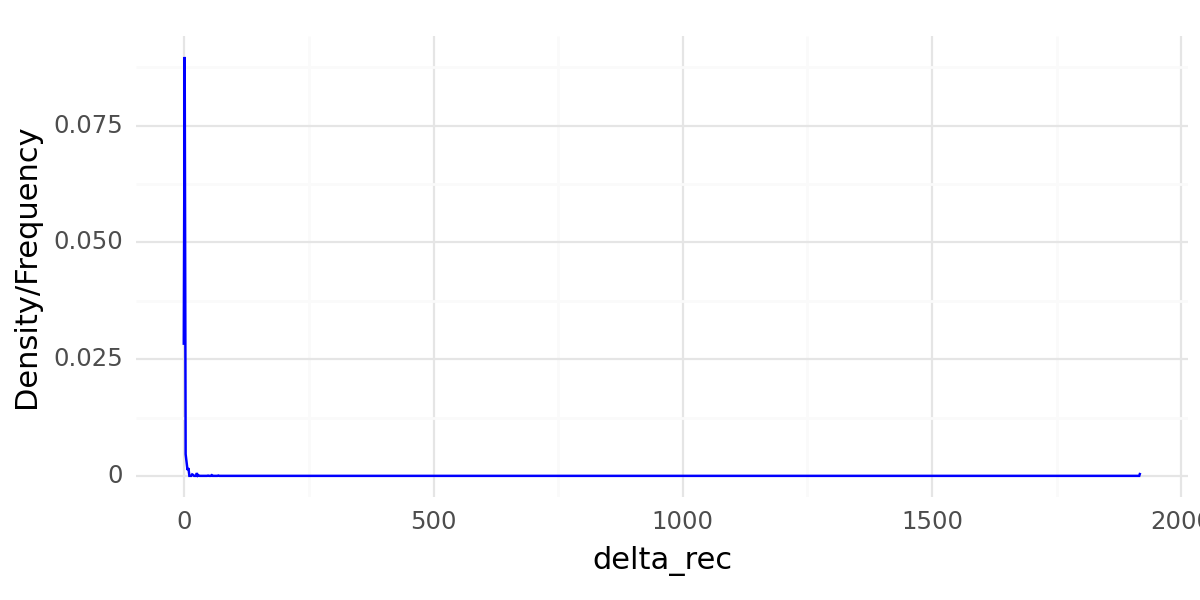

<Figure Size: (600 x 300)>

In [84]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='delta_rec', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [85]:
# we then log adjust to make the distribution more normal
adjusted_dataset = (adjusted_dataset
 .assign(
     delta_rec = lambda x:  np.log(x['delta_rec'])
 )
)

/home/erik/jupyterlab/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
/home/erik/jupyterlab/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log


/home/erik/jupyterlab/env/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 8323 rows containing non-finite values.


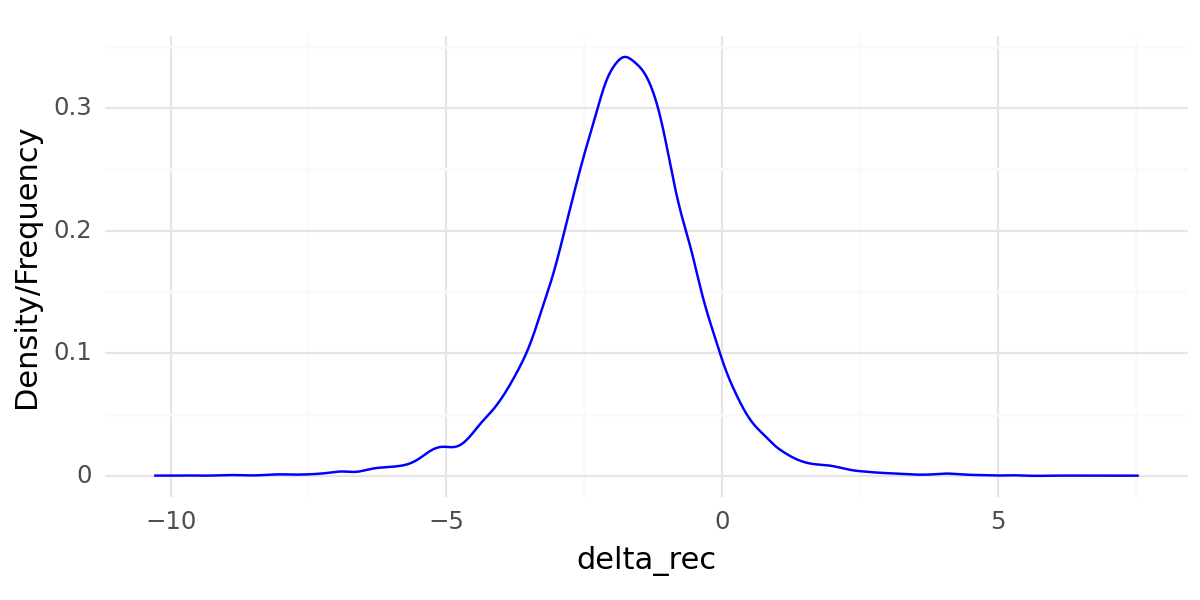

<Figure Size: (600 x 300)>

In [86]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='delta_rec', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

And property, plant and equipment.

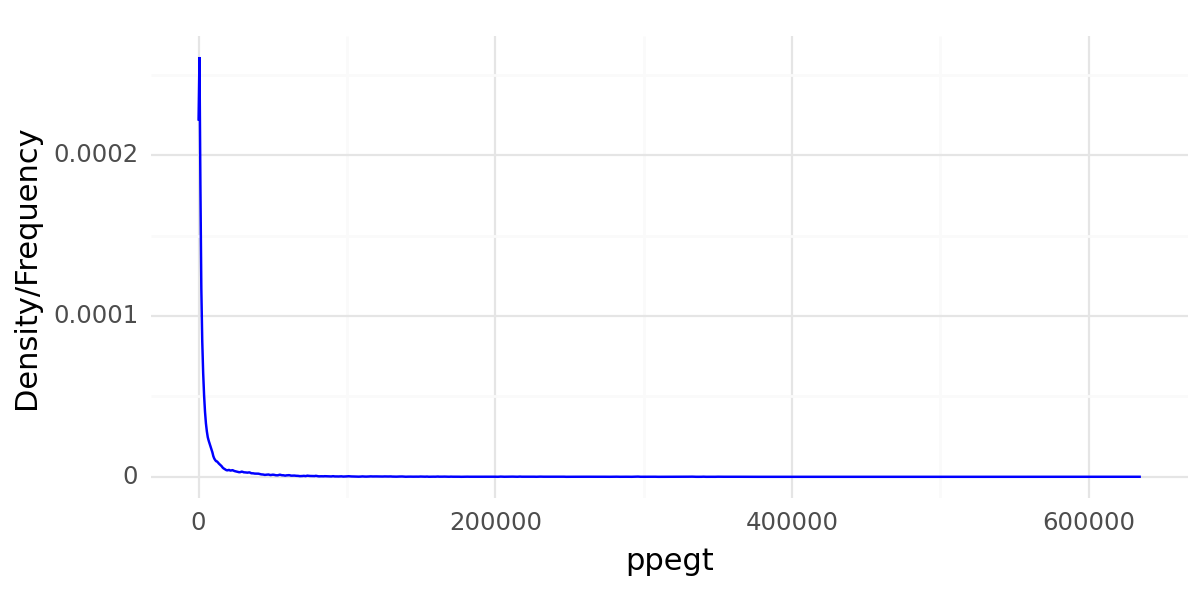

<Figure Size: (600 x 300)>

In [87]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='ppegt', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [88]:
# we then log adjust to make the distribution more normal
adjusted_dataset = (adjusted_dataset
 .assign(
     ppegt = lambda x:  np.log(x['ppegt'])
 )
)

/home/erik/jupyterlab/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


/home/erik/jupyterlab/env/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 41 rows containing non-finite values.


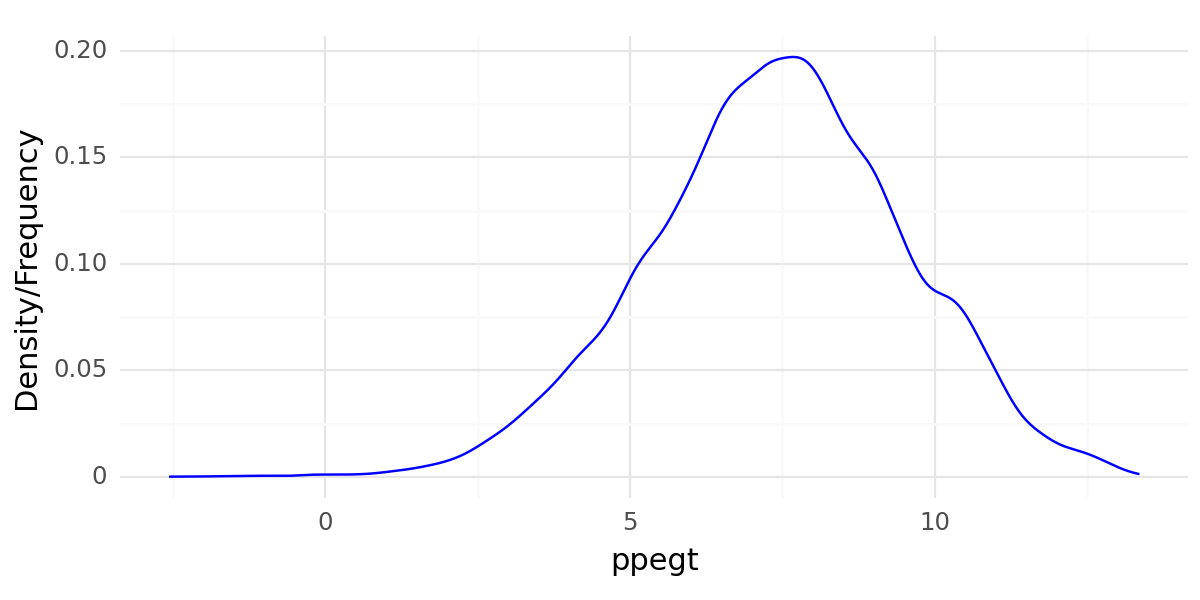

<Figure Size: (600 x 300)>

In [89]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='ppegt', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Calculate the logs in some cases led to infinite value, we remove these from the data set. 

In [90]:
adjusted_dataset = ( adjusted_dataset
                    .replace([np.inf, -np.inf], np.nan)
                    .dropna()
                   )

In [91]:
len(adjusted_dataset)

14495

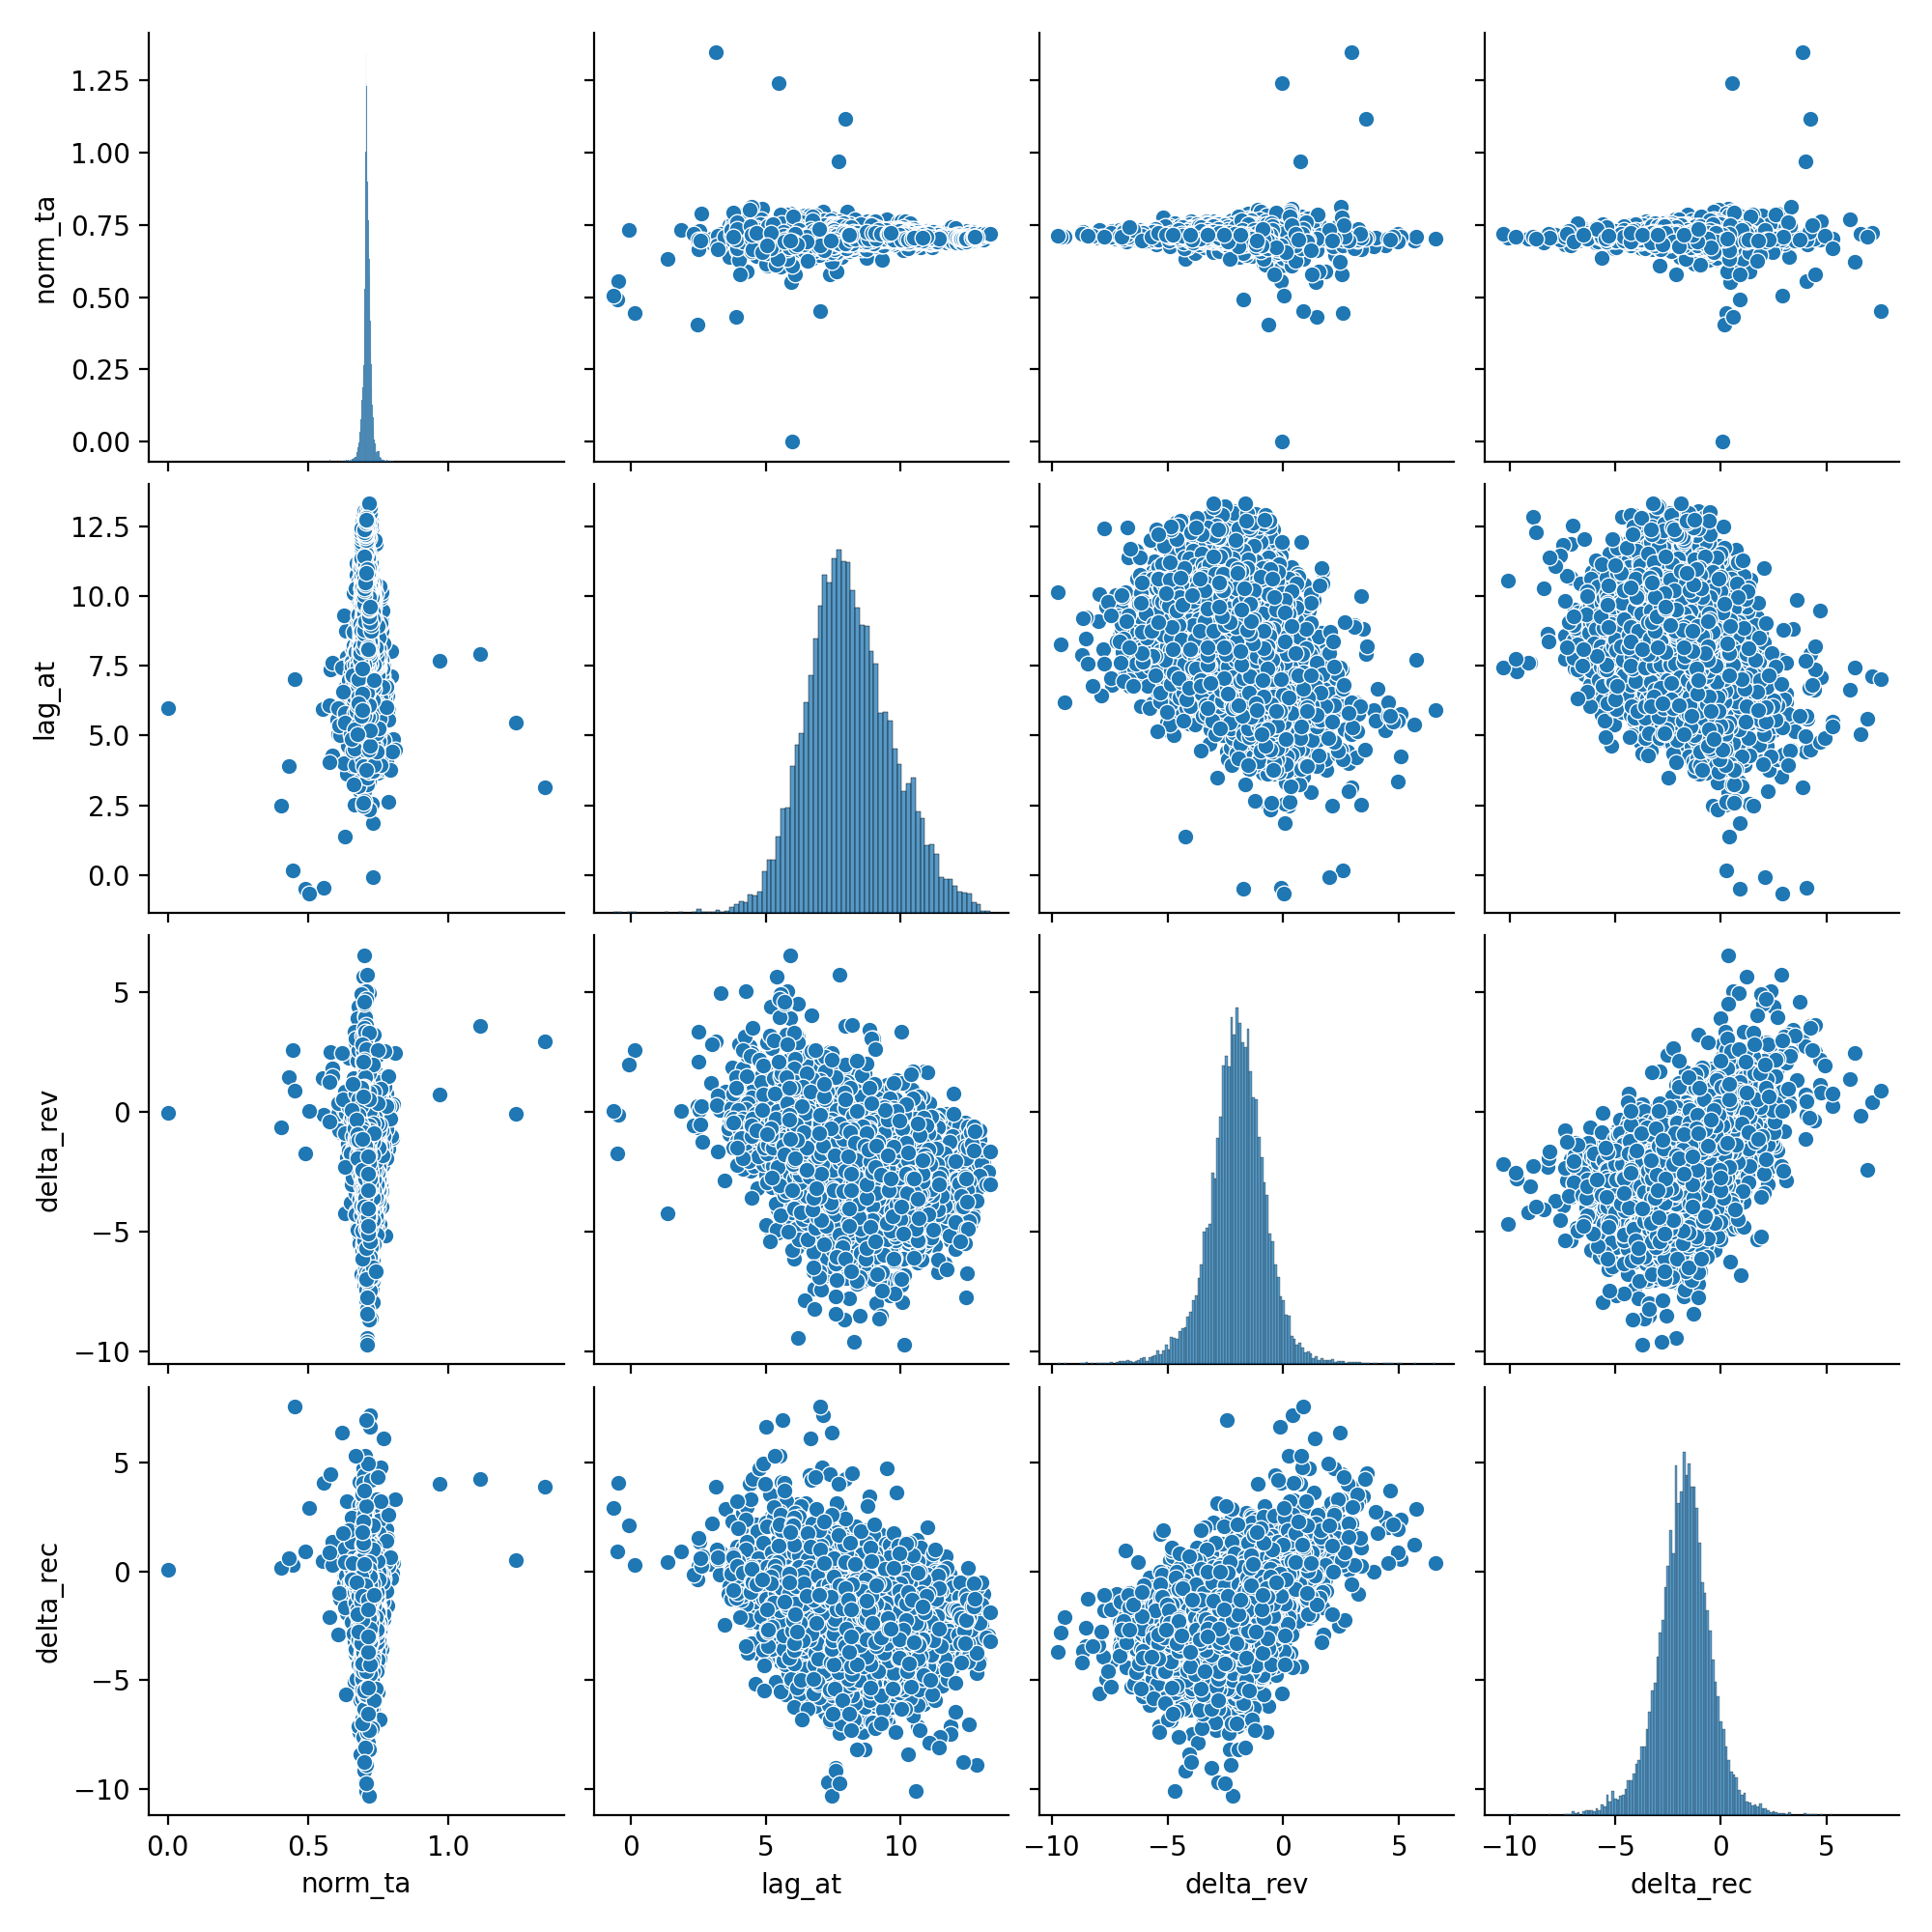

In [92]:
sns.pairplot(adjusted_dataset.get(["norm_ta", "lag_at","delta_rev","delta_rec"]))

## First Stage: Estimate Discretionary Accruals

In [93]:
df_ = adjusted_dataset.copy()

In [ ]:
# First stage regression to estimate normal accruals 
fit_stage_1 = smf.ols('norm_ta ~ lag_at + delta_rev + delta_rec + ppegt', data=df_).fit()

In [109]:
# First stage regression after inspection: (run 2nd)
# remove lag_at vs. ppegt and use robust cov (stage 2)
# remove outliers by Cook's distance (2nd run)
#df_ = df_[cooks_d < 0.002]
#  fit_stage_1 = smf.ols('norm_ta ~ lag_at + delta_rev + delta_rec ', data=df_).fit(cov_type='HC3')

In [110]:
fit_stage_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                norm_ta   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     112.1
Date:                Mon, 20 May 2024   Prob (F-statistic):           1.00e-71
Time:                        04:25:55   Log-Likelihood:                 41687.
No. Observations:               14445   AIC:                        -8.337e+04
Df Residuals:                   14441   BIC:                        -8.334e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7155      0.001   1051.993      0.000       0.714       0.717
lag_at        -0.0009   7.57e-05    -12.181      0.000      -0.001      -0.001
delta_rev     -0.0010   9.57e-05    -10.247      0.000      -0.001      -0.001
delta_rec     -0.0006    9.4e-05     -6.810      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1249.658   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8157.148
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                       6.677   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [113]:
fit_ = fit_stage_1

Strong evidence for Heteroskedasticity - use HC3 covariance estimators.

In [101]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(fit_.resid, fit_.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 112.5568591778117),
 ('p-value', 3.090458515833081e-24),
 ('f-value', 37.80214136489268),
 ('f p-value', 2.519633014780595e-24)]

We see some strong outliers. 

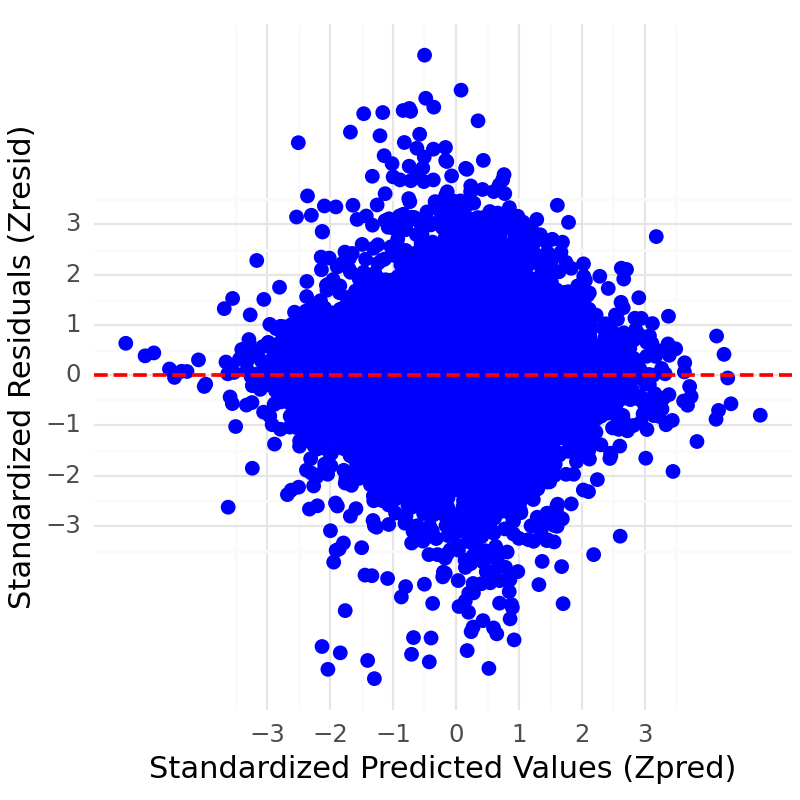

<Figure Size: (400 x 400)>

In [114]:
# Get predicted values and residuals
predicted_values = fit_.predict(df_)
residuals = fit_.resid

# Create a plot dataframe with normalized values
plot_data = pd.DataFrame({
    'Zpred': (predicted_values - np.mean(predicted_values)) / np.std(predicted_values),
    'Zresid': (residuals - np.mean(residuals)) / np.std(residuals)
})

# Create the plot
(
    ggplot(plot_data, aes(x='Zpred', y='Zresid'))  # Define the data and aesthetic mapping
    + geom_point(color='blue', size=2)  # Scatterplot points
    + geom_hline(yintercept=0, color='red', linetype='dashed', size=0.75)  # Horizontal line at zero
    + labs(x='Standardized Predicted Values (Zpred)', y='Standardized Residuals (Zresid)')  # Labels
    + theme_minimal()  # Minimal theme for a clean look
    + scale_x_continuous(breaks=np.arange(-3, 4, 1))  # Customize the x-axis breaks
    + scale_y_continuous(breaks=np.arange(-3, 4, 1))  # Customize the y-axis breaks
    + theme(figure_size=(4, 4)) 
)

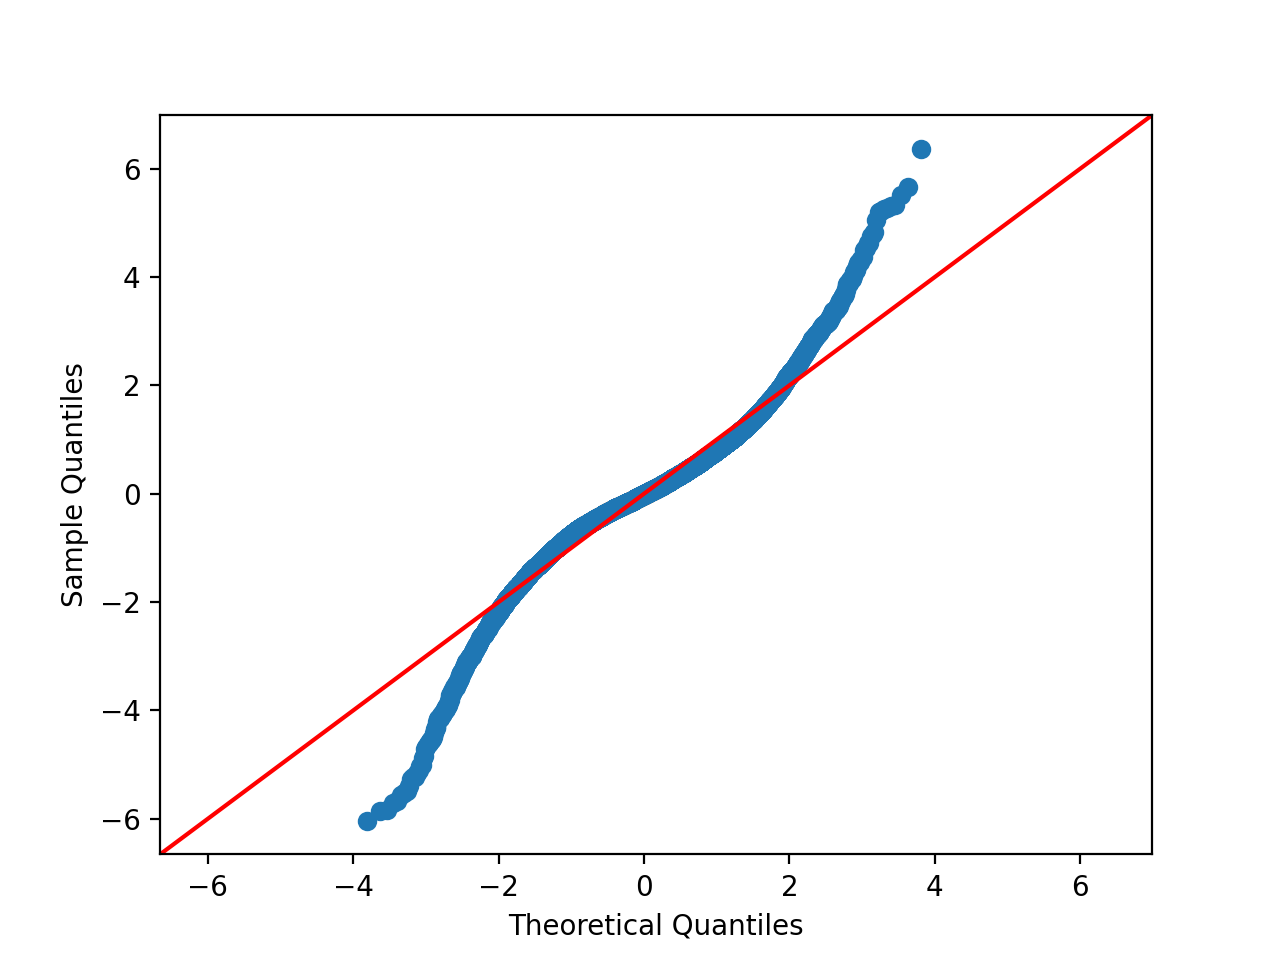

In [115]:
sm.qqplot(fit_.resid,  fit=True, line='45');

Strong multicollinearit between lag_at an ppegt.  Consider removing one of them. 

In [104]:
df_VIF_selected = df_.get(["norm_ta", "lag_at","delta_rev","delta_rec","ppegt"])

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df_VIF_selected.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_VIF_selected.values, i) 
                          for i in range(len(df_VIF_selected.columns))] 
vif_data

,feature,VIF
0,norm_ta,28.889926
1,lag_at,100.689050
2,delta_rev,4.880232
3,delta_rec,3.763452
4,ppegt,47.125594


In [105]:
fit_.condition_number

45.49534219891909

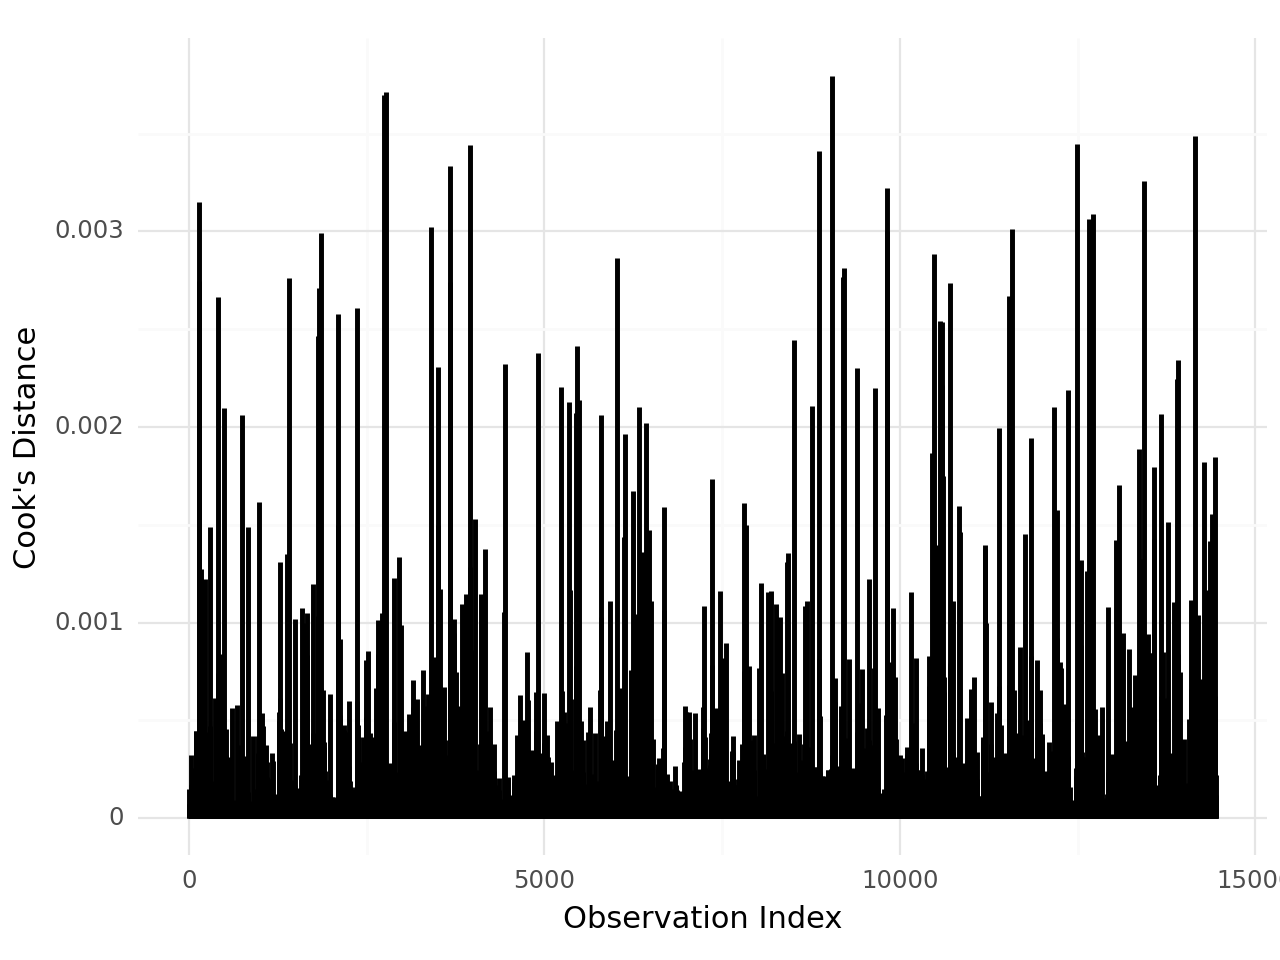

<Figure Size: (640 x 480)>

In [116]:
# Calculate influence measures
influence = fit_.get_influence()

# Obtain Cook's distance for each observation
cooks_d, pvals = influence.cooks_distance

# Create DataFrame for plotting
data = pd.DataFrame({
    'Observation Index': np.arange(len(cooks_d)),
    'Cook\'s Distance': cooks_d
})

(
    ggplot(data, aes(x='Observation Index', y='Cook\'s Distance'))
    + geom_segment(aes(x='Observation Index', xend='Observation Index', y=0, yend='Cook\'s Distance'), size=1)  # Create vertical lines (like stems)
    #+ geom_point(shape='o', color='blue', size=2)  # Add points to the tips of stems
    + labs( x='Observation Index', y="Cook's Distance")
    + theme_minimal()  # Apply a minimalistic theme
)

Omnibus and Durbin Watson (autocorrelation in the residuals) indicate that residuals might not be distributed entirely normally.  Breusch-Pagan and zpred/zresid indicates that there is some level of heteroskedasticity.  QQ plot shows clearly that a linear model might not explain the results the best. 

PPEGT and lag_ta exhibit strong collinearity based on VIF. 



In [107]:
np.sum(cooks_d > 0.002)

50

Save our calculated discretional accruals.

In [117]:
df_["discretionary_accruals"]  = fit_.resid

## Data Preparation for Second Stage

In [118]:
adjusted_dataset = df_

Handle long tail outliers in roa.

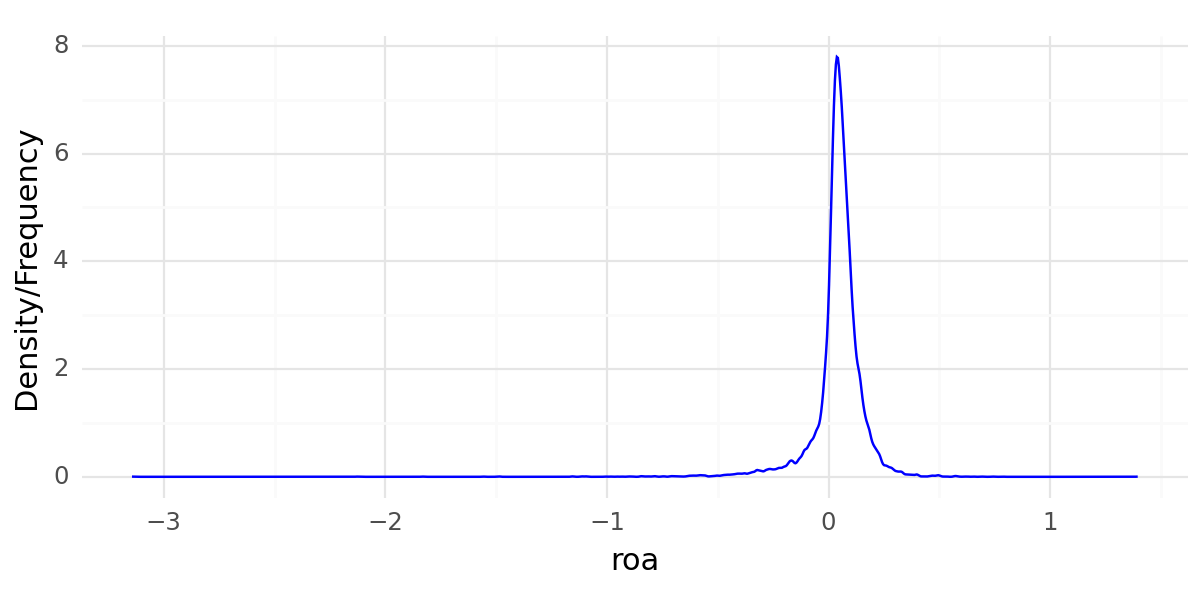

<Figure Size: (600 x 300)>

In [119]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='roa', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [120]:
adjusted_dataset = (adjusted_dataset
 .assign(
     roa = lambda x: np.log( x['roa'].max() - x['roa'] + 1 )
 )
)

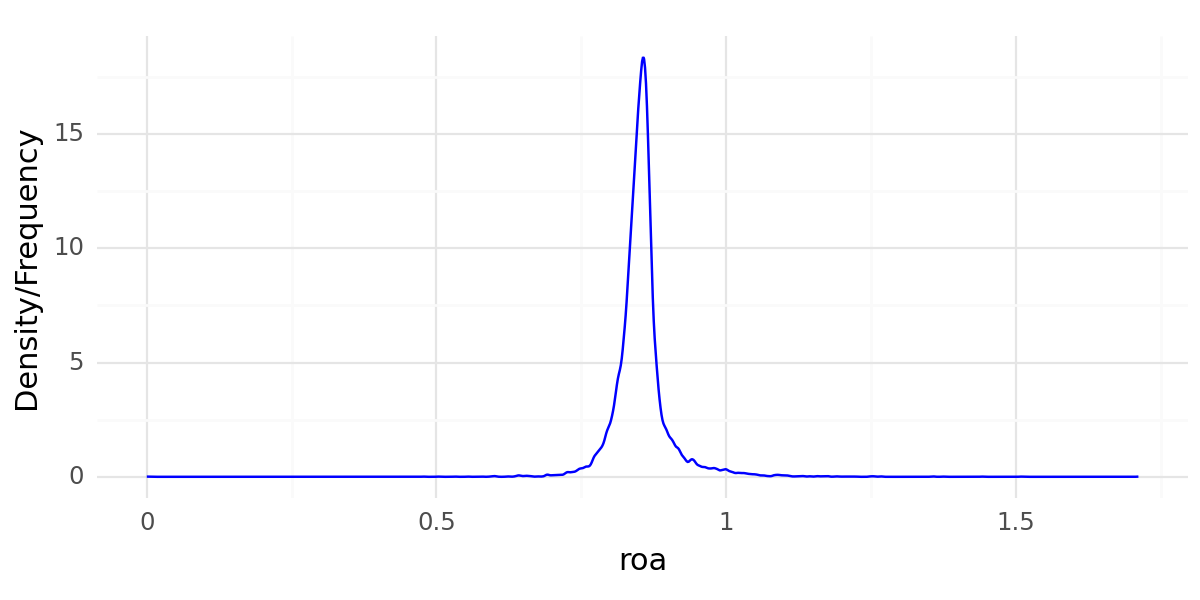

<Figure Size: (600 x 300)>

In [121]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='roa', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Log adjust firm size.

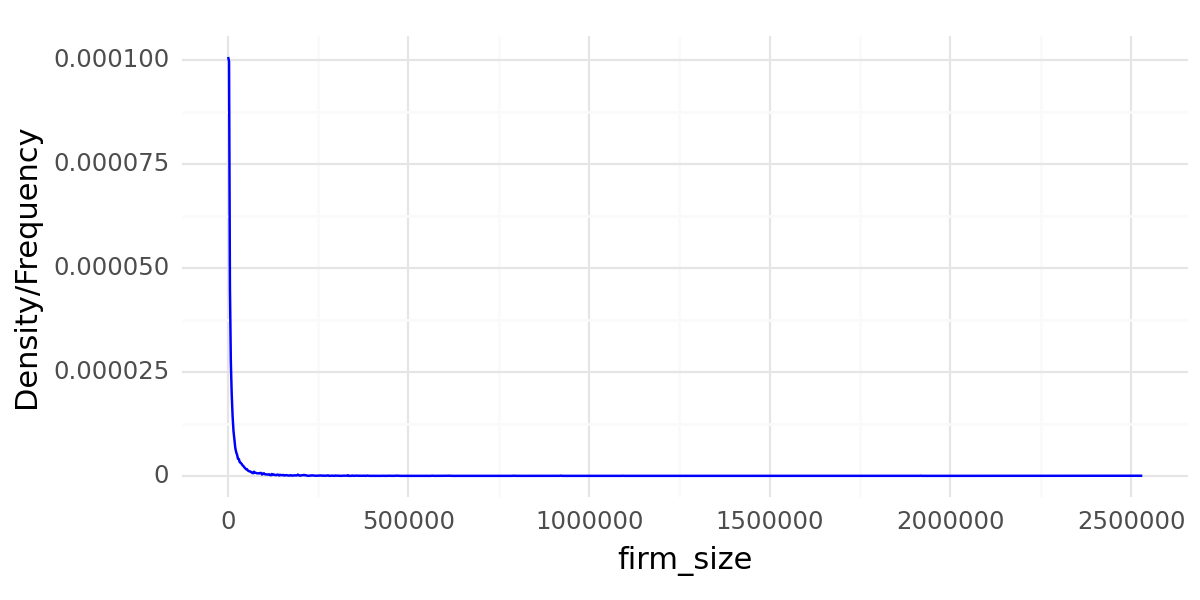

<Figure Size: (600 x 300)>

In [122]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='firm_size', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [123]:
# we then log adjust to make the distribution more normal
adjusted_dataset = (adjusted_dataset
 .assign(
     firm_size = lambda x:  np.log(x['firm_size'])
 )
)

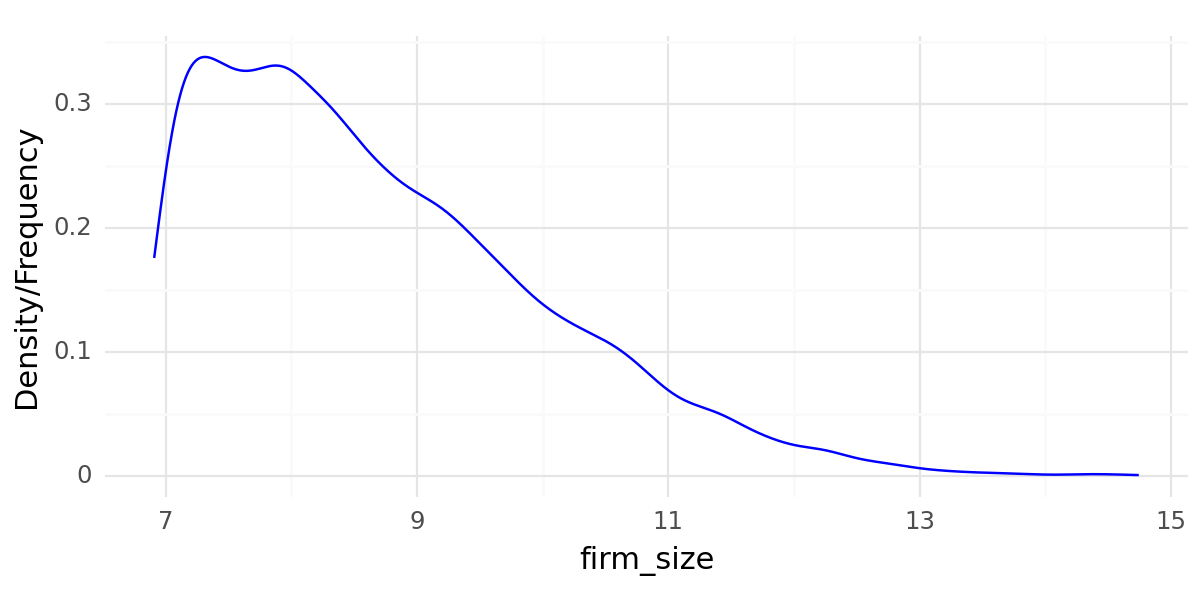

<Figure Size: (600 x 300)>

In [124]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='firm_size', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Log adjust market to book as well. 

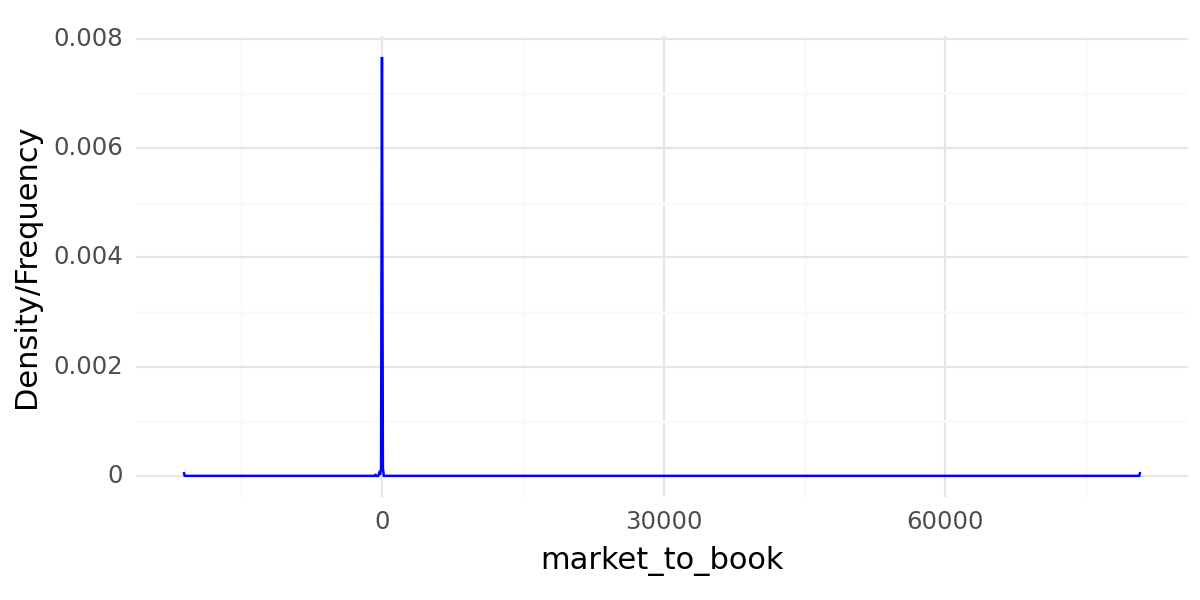

<Figure Size: (600 x 300)>

In [125]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='market_to_book', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

In [126]:
adjusted_dataset = (adjusted_dataset
 .assign(
     market_to_book = lambda x:  np.log(x['market_to_book'])
 )
)

/home/erik/jupyterlab/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log


/home/erik/jupyterlab/env/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 512 rows containing non-finite values.


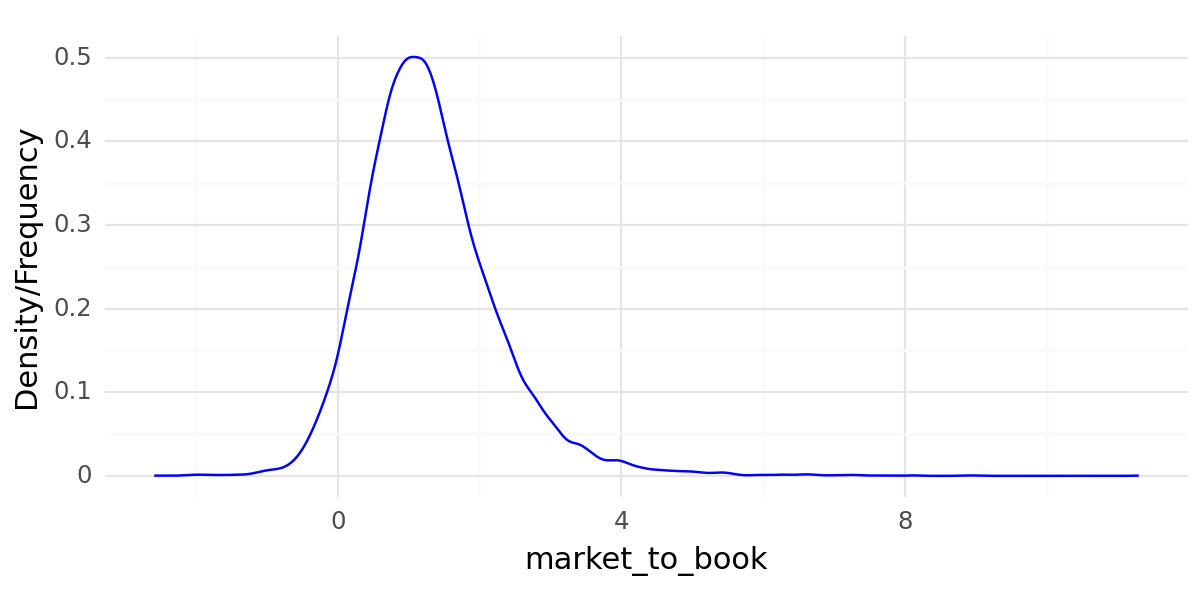

<Figure Size: (600 x 300)>

In [127]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='market_to_book', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)

Discretionary accruals look good.

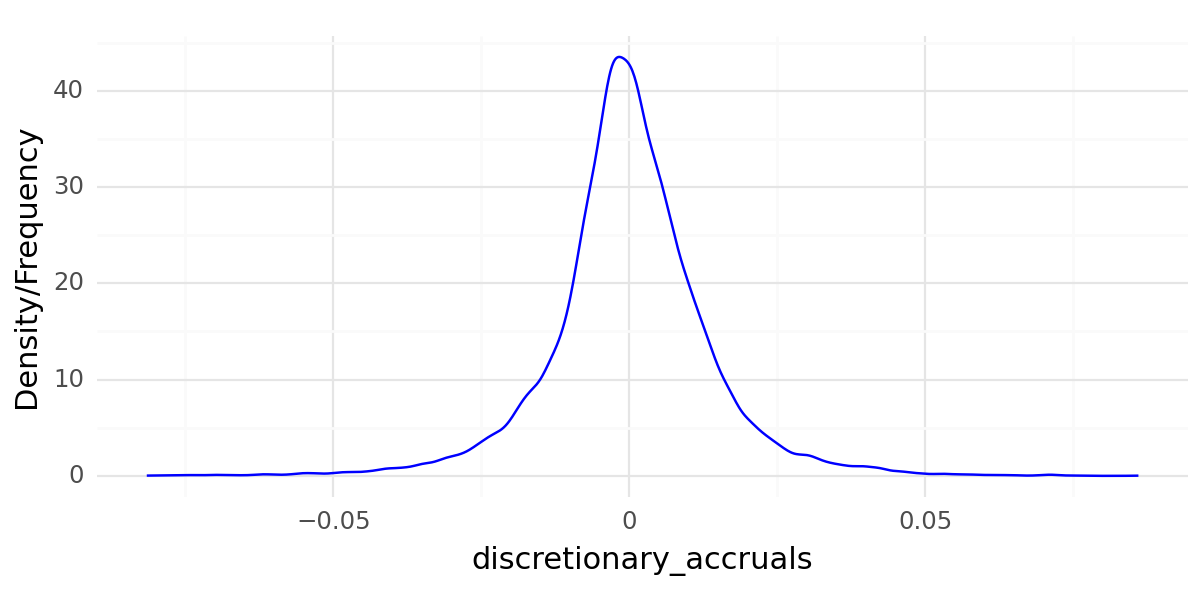

<Figure Size: (600 x 300)>

In [128]:
( ggplot(adjusted_dataset) 
   + geom_density(aes(x='discretionary_accruals', y='stat(density)'), color='blue') 
   + labs(y='Density/Frequency') 
   + theme_minimal()
   + theme(figure_size=(6, 3))
)


In [129]:
adjusted_dataset = ( adjusted_dataset
                    .replace([np.inf, -np.inf], np.nan)
                    .dropna()
                   )

In [130]:
len(adjusted_dataset)

13933

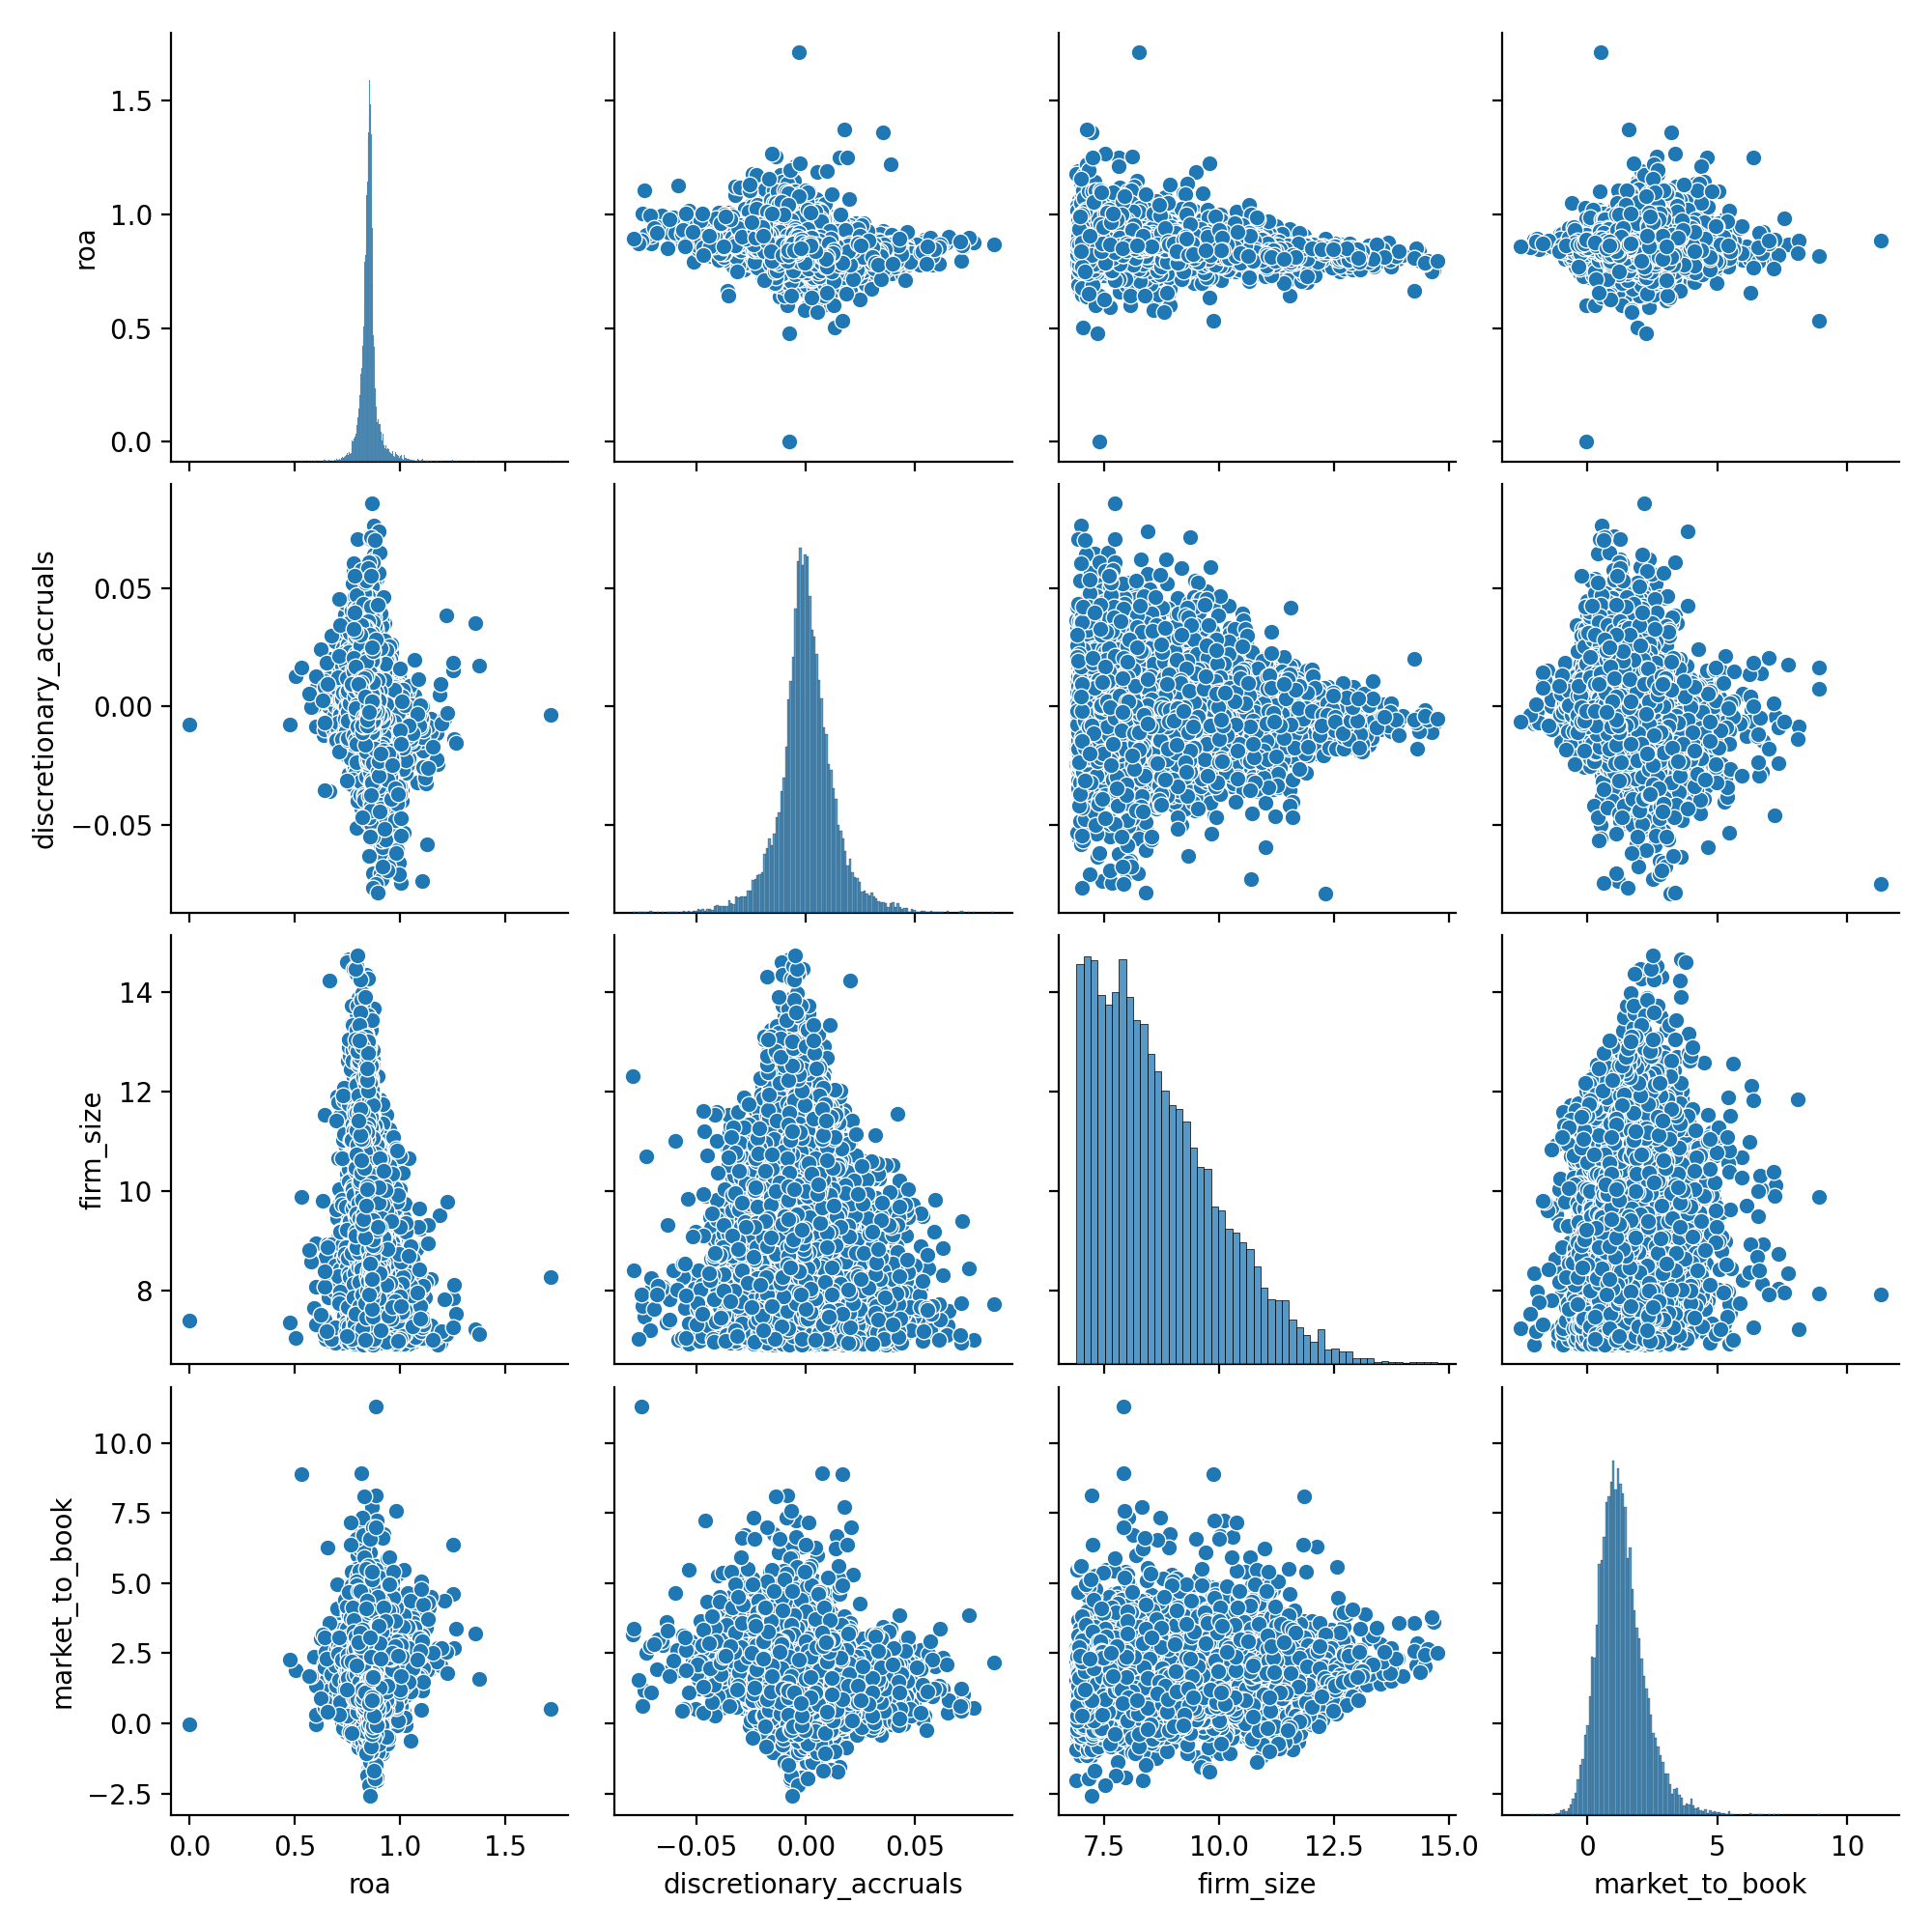

In [132]:
sns.pairplot(adjusted_dataset.get(["roa", "discretionary_accruals", "firm_size", "market_to_book"]))

## Second Stage: Examine the Impact of Earnings Management

In [169]:
df_ = adjusted_dataset.copy()

In [170]:
# Define the model with interaction terms
formula = 'roa ~ discretionary_accruals + firm_size + market_to_book  +\
            discretionary_accruals:firm_size + discretionary_accruals:market_to_book'

In [171]:
fit_stage_2 = smf.ols(formula=formula, data=df_).fit()

In [181]:
# removal of outliers 
df_ = df_[cooks_d < 0.002]

# Because we still have some concerns about heteroskedasticity, we fit the model again with robust standard errors. 
fit_stage_2 = smf.ols(formula=formula, data=df_).fit(cov_type='HC3')

In [182]:
fit_stage_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roa   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     307.6
Date:                Mon, 20 May 2024   Prob (F-statistic):          2.73e-313
Time:                        04:39:37   Log-Likelihood:                 25479.
No. Observations:               13835   AIC:                        -5.095e+04
Df Residuals:                   13829   BIC:                        -5.090e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.9085      0.002    424.267      0.000       0.904       0.913
discretionary_accruals                   -1.3337      0.181     -7.375      0.000      -1.688      -0.979
firm_size                                -0.0060      0.000    -24.410      0.000      -0.007      -0.006
market_to_book                           -0.0029      0.000     -6.308      0.000      -0.004      -0.002
discretionary_accruals:firm_size          0.1431      0.022      6.618      0.000       0.101       0.186
discretionary_accruals:market_to_book    -0.4653      0.029    -16.064      0.000      -0.522      -0.409
==============================================================================
Omnibus:                     2918.477   Durbin-Watson:                   1.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37912.851
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                      11.007   Cond. No.                     5.02e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 5.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [183]:
fit_ = fit_stage_2

Heteroskedasticity is present - need to use robust standard errors.

In [184]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(fit_.resid, fit_.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 713.8983927072164),
 ('p-value', 4.853229866326174e-152),
 ('f-value', 150.48280499955735),
 ('f p-value', 4.093007898768538e-156)]

Some extreme outliers present in the residuals. Shoudl re-run after removing. 

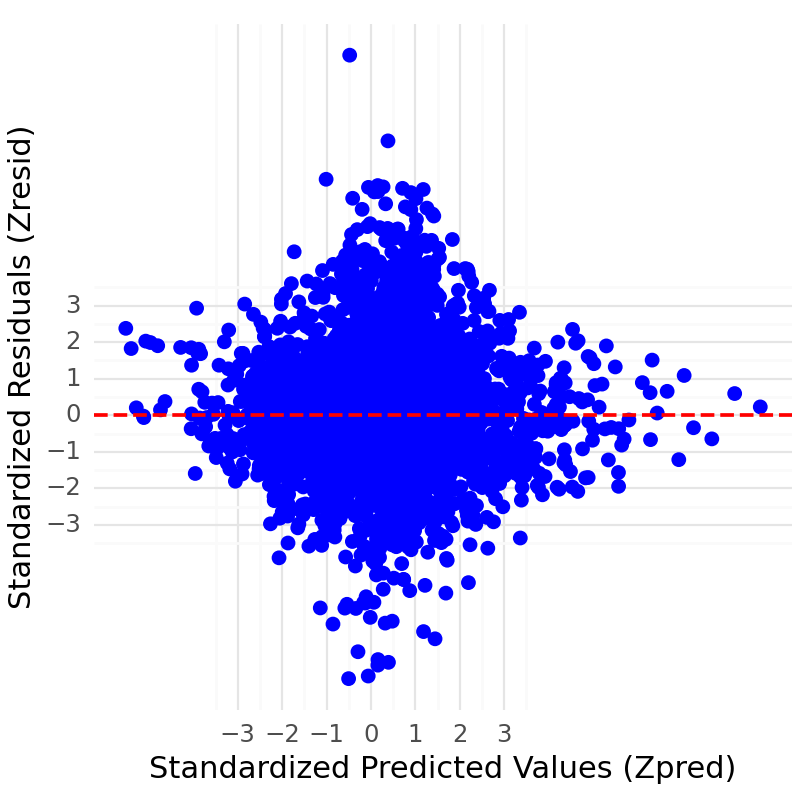

<Figure Size: (400 x 400)>

In [185]:
# Get predicted values and residuals
predicted_values = fit_.predict(df_)
residuals = fit_.resid

# Create a plot dataframe with normalized values
plot_data = pd.DataFrame({
    'Zpred': (predicted_values - np.mean(predicted_values)) / np.std(predicted_values),
    'Zresid': (residuals - np.mean(residuals)) / np.std(residuals)
})

# Create the plot
(
    ggplot(plot_data, aes(x='Zpred', y='Zresid'))  # Define the data and aesthetic mapping
    + geom_point(color='blue', size=2)  # Scatterplot points
    + geom_hline(yintercept=0, color='red', linetype='dashed', size=0.75)  # Horizontal line at zero
    + labs(x='Standardized Predicted Values (Zpred)', y='Standardized Residuals (Zresid)')  # Labels
    + theme_minimal()  # Minimal theme for a clean look
    + scale_x_continuous(breaks=np.arange(-3, 4, 1))  # Customize the x-axis breaks
    + scale_y_continuous(breaks=np.arange(-3, 4, 1))  # Customize the y-axis breaks
    + theme(figure_size=(4, 4)) 
)

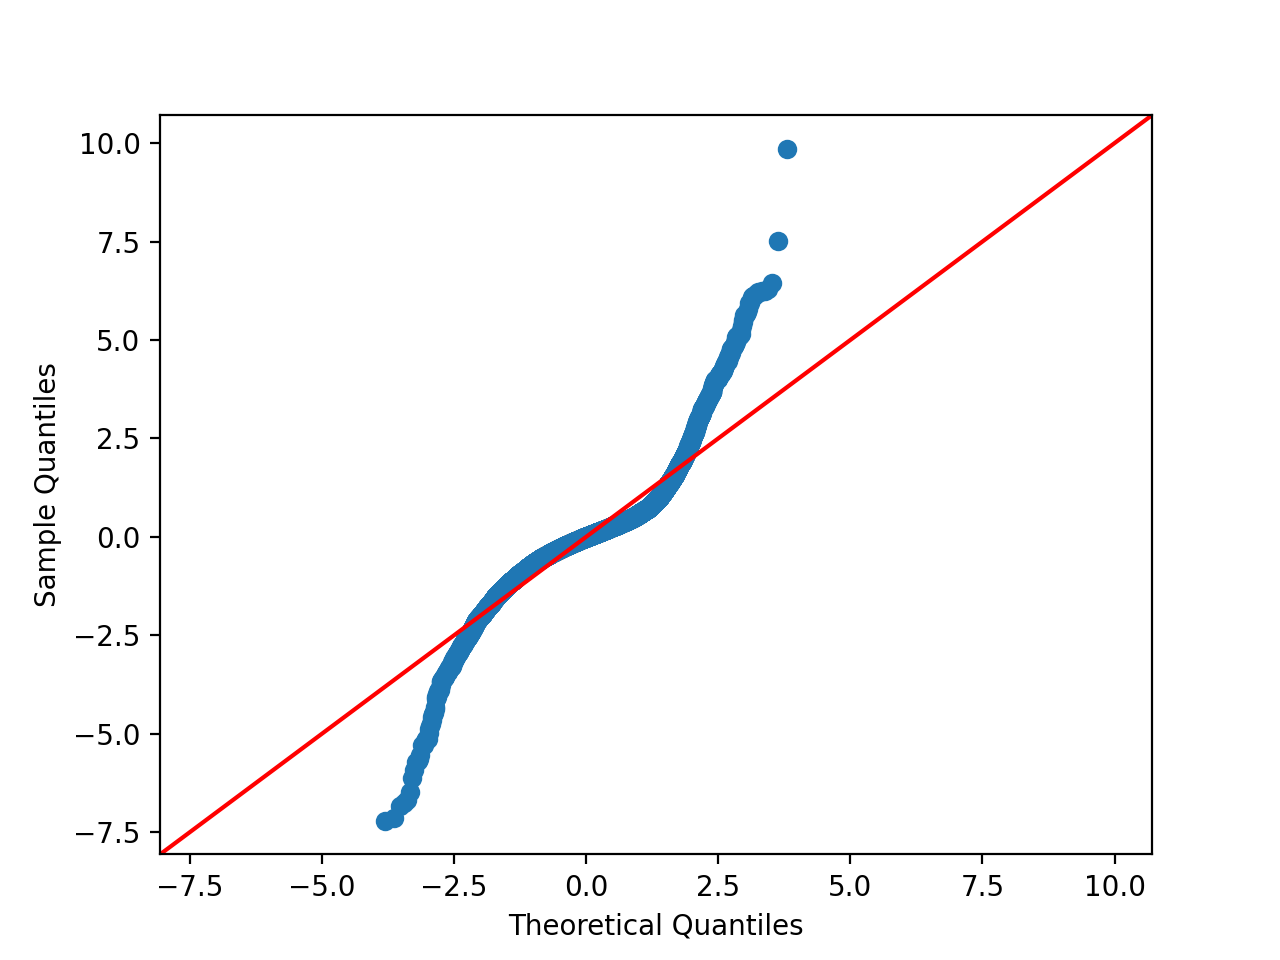

In [186]:
sm.qqplot(fit_.resid,  fit=True, line='45');

In [187]:
df_VIF_selected = df_.get(["discretionary_accruals","firm_size","market_to_book"])

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = df_VIF_selected.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(df_VIF_selected.values, i) 
                          for i in range(len(df_VIF_selected.columns))] 
vif_data

,feature,VIF
0,discretionary_accruals,1.050395
1,firm_size,3.204012
2,market_to_book,3.245699


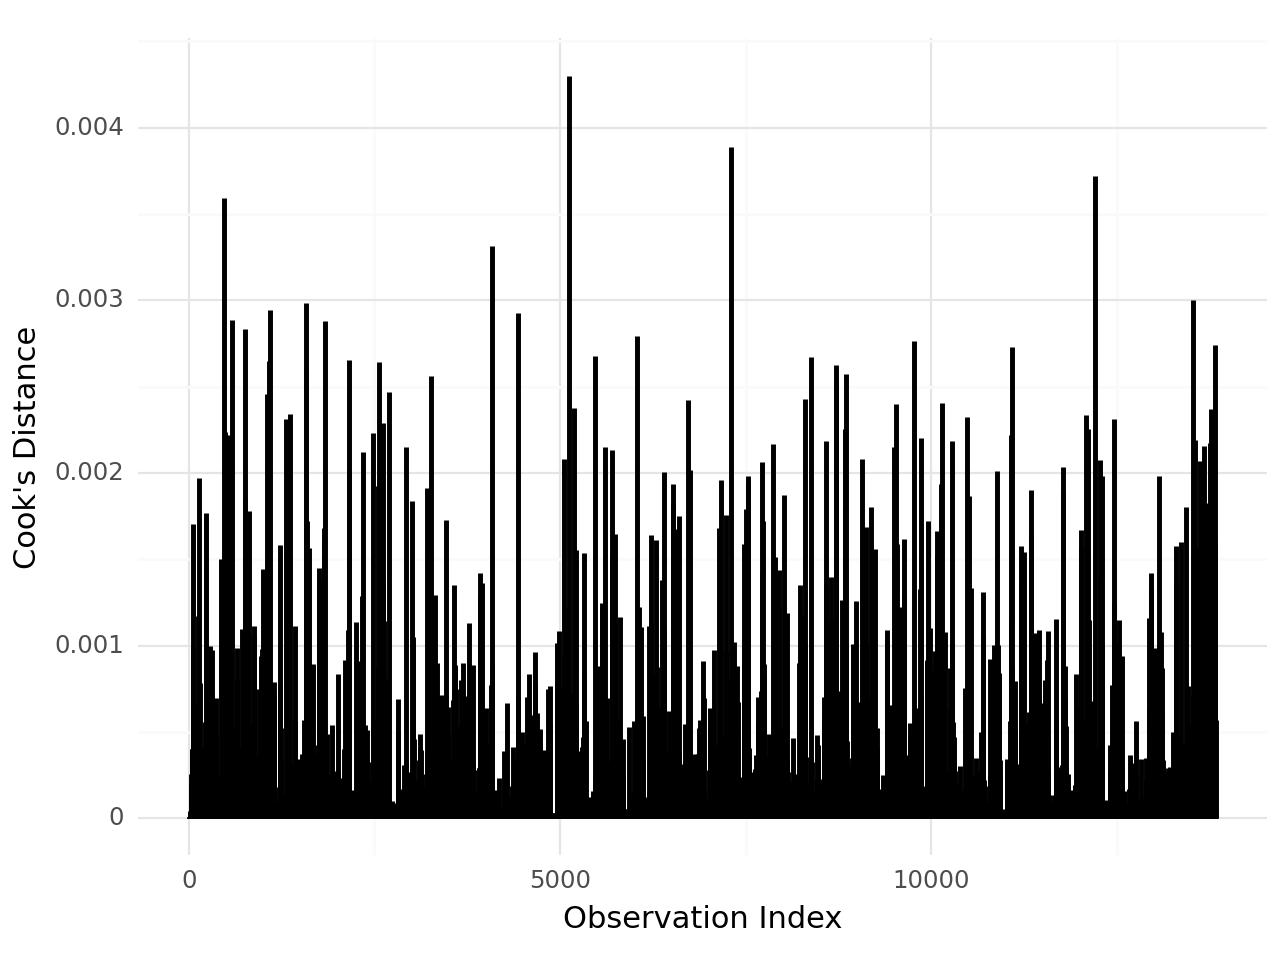

<Figure Size: (640 x 480)>

In [188]:
# Calculate influence measures
influence = fit_.get_influence()

# Obtain Cook's distance for each observation
cooks_d, pvals = influence.cooks_distance

# Create DataFrame for plotting
data = pd.DataFrame({
    'Observation Index': np.arange(len(cooks_d)),
    'Cook\'s Distance': cooks_d
})

(
    ggplot(data, aes(x='Observation Index', y='Cook\'s Distance'))
    + geom_segment(aes(x='Observation Index', xend='Observation Index', y=0, yend='Cook\'s Distance'), size=1)  # Create vertical lines (like stems)
    #+ geom_point(shape='o', color='blue', size=2)  # Add points to the tips of stems
    + labs( x='Observation Index', y="Cook's Distance")
    + theme_minimal()  # Apply a minimalistic theme
)

In [189]:
np.sum(cooks_d > 0.002)

72

## Results and Interpretation

The results from the two-stage regression analysis provide significant insights into the impact of discretionary accruals on return on assets (ROA), considering the influence of firm size and market-to-book ratio, as well as their interactions with discretionary accruals. The analysis helps evaluate the proposed hypotheses regarding earnings management and its impact on firm performance.
Model Overall

The model's R-squared value of 0.122 indicates that approximately 12.2% of the variance in ROA is explained by the model. While this percentage is not overwhelmingly high, it is fairly common in financial studies due to the multitude of unobserved factors affecting firm performance. The highly significant F-statistic, with a p-value of $<0.001$, suggests that the model is statistically significant overall, reinforcing the robustness of the explanatory variables included in the analysis.

Coefficients and Interpretations

The coefficient for discretionary accruals is -1.3337, which is statistically significant with a p-value less than 0.0001. This negative coefficient indicates that an increase in discretionary accruals is associated with a decrease in ROA. This finding contradicts Hypothesis 1 (H1), which posited that discretionary accruals would be positively associated with ROA. Instead, the results suggest that higher levels of earnings management activities, as measured by discretionary accruals, might be perceived negatively, potentially indicating manipulation that could harm firm performance.

Firm size, with a coefficient of -0.0060 and a highly significant p-value, shows a negative relationship with ROA. This suggests that larger firms, on average, report lower profitability, which could be due to inefficiencies or increased operational complexities associated with larger size. The interaction between discretionary accruals and firm size has a positive coefficient of 0.1431, which is statistically significant. This positive interaction supports Hypothesis 2 (H2), indicating that the negative impact of discretionary accruals on ROA diminishes as firm size increases. Larger firms may have more resources and mechanisms to manage or mask the negative effects of earnings management.

The market-to-book ratio shows a negative coefficient of -0.0029, with a significant p-value. This indicates that firms with higher market valuations relative to their book value tend to have lower ROA, which might reflect market overvaluation or other underlying issues affecting profitability. The interaction between discretionary accruals and market-to-book ratio has a negative coefficient of -0.4653, which is highly significant. This finding supports Hypothesis 3 (H3), suggesting that firms with higher market-to-book ratios experience a more pronounced negative effect from discretionary accruals on ROA. Higher-growth or more favorably viewed firms might be under greater scrutiny, and earnings management in such firms could be more detrimental to perceived performance.
Interaction Terms

The interaction terms provide further insights into the hypotheses. The positive interaction between discretionary accruals and firm size indicates that larger firms may be less negatively impacted by earnings management, possibly due to their ability to manage or mask the effects more effectively. Conversely, the negative interaction between discretionary accruals and market-to-book ratio suggests that higher market valuations exacerbate the negative impact of earnings management, likely due to heightened scrutiny and expectations from the market.
Model Diagnostics

The Durbin-Watson statistic of 1.080 indicates potential positive autocorrelation in the residuals, suggesting that further investigation or adjustments to the model might be necessary. Additionally, significant Omnibus and Jarque-Bera tests point to non-normality in the residuals, which could affect the robustness of standard errors, even though heteroskedasticity-consistent (HC3) estimates were used.


Conclusion

The analysis confirms several key hypotheses about the influence of discretionary accruals and firm characteristics on financial performance, highlighting the complex interplay between firm size, market perception, and earnings management. The negative direct impact of discretionary accruals on ROA contradicts the initial hypothesis that earnings management would positively influence profitability. Instead, it suggests that higher levels of earnings management might be detrimental to firm performance. The interaction effects reveal that larger firms can mitigate these negative impacts, while firms with higher market-to-book ratios experience more significant negative consequences. These insights are crucial for investors, regulators, and corporate managers as they navigate financial reporting standards and assess firm health. Further investigations might focus on addressing the autocorrelation in the residuals and exploring the effects of non-normality to enhance the model's robustness.

# Assignment

This week you have a choice of assignments.  Each of these builds on the examples we discuss during immersion.  Pick your topic and create a written report with a minimum of one graph and one table for your results.  In your report, briefly develop an hypothesis based on the literature and reason how your findings correspond to your expectations. 

Topic 1: 
- Analyze if firm leverage has an influence on the relationship between discretionary accruals and firm performance.  Use the Jones model to calculate discretionary accruals.  To calculate leverage, you'll need to download additional variables from Compustat for total debt (long term and short term liabilities) and total assets.  Calculate leverage as $leverage = \frac{\text{long term debt} + \text{short term debt}}{\text{lagged total assets}}$.  Make sure you review the variable before using it in the regression and adjust it as necessary.  

---- OR ----

Topic 2: 
- Instead of the wave height, use the 2-day average maximum wind speed as the IV in the regression to assess demand elasticity of the Fulton Fish Market.  Are your results similar?   Do you believe this is a better IV than wave height?  Discuss if and why the use of two-stage-least-squares was necessary based on your results with and without the use of this method. 
